In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import numpy
import torch
from time import time
from tqdm import tqdm

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [4]:
from utils.tools import *

# Constants

In [5]:
INPUT_DIM = 50
BIAS = False

SEED = 42
N_TRAIN = 256
ALPHA = 1e-1
BASE_LR = 1.0e-2
N_STEPS = int(2e4)
N_VAL = 100
VAL_ITER = 100
N_MAX_NEURONS = 2000

EPS = 1.0e-7
ALPHA = 1.0
BETA = 1.0
LAMBDA = 0.02

In [6]:
FIGURES_DIR = os.path.join(ROOT, 'figures/prox_variants/')
create_dir(FIGURES_DIR)

In [7]:
set_random_seeds(SEED)

## Common functions

In [8]:
def forward(a, b, x):
    m = a.shape[1]
    if m == 0:
        return 0.
    return np.matmul(np.maximum(np.matmul(x, b.T), 0), a.T) #/ m #/ a.shape[1]

In [9]:
def compute_losses(a, b, x, y, penalized=True):
    y_hat = forward(a, b, x)
    loss_ = 0.5 * np.mean((y_hat - y)**2)
    if penalized:
        penalized_loss = loss_ + LAMBDA * np.sum(np.abs(a))
    else:
        penalized_loss = 0.
    return loss_, penalized_loss

In [10]:
def soft_thresholding(V, tau):
    return - np.sign(V) * np.maximum(0, np.abs(V) - tau)

In [11]:
def V_grad(a, b, x, y, new_b):
    y_hat = forward(a, b, x)
    if len(new_b.shape) < 2:
        new_b = new_b.reshape(1, -1)
    V_grad_ = np.mean((y_hat - y) * np.maximum(np.matmul(x, new_b.T), 0), axis=0)
    if len(V_grad_) == 1:
        return V_grad_[0]
    else:
        return V_grad_

In [12]:
def nabla_V_grad(a, b, x, y):
    n = len(x)
    m = a.shape[1]
    y_hat = forward(a, b, x)
    # M = (y_hat - y) * np.heaviside(np.matmul(x, b.T * a), 0)
    M = (y_hat - y) * np.heaviside(np.matmul(x, b.T), 0) * (m * a)
    return np.matmul(M.T, x) / n    

# Data

In [13]:
# Teacher Network
m_star = 50 # number of teacher neurons
eps = 3e-1

a_star = 2 * np.sign(np.random.uniform(size=(1, m_star)) - 0.5) / np.sqrt(m_star)
b_star = 2 * np.random.uniform(size=(m_star, INPUT_DIM)) - 1 - eps * np.random.normal(size=(m_star, INPUT_DIM))**2

In [14]:
# Data with inputs on the sphere
x_train = np.random.normal(size=(N_TRAIN, INPUT_DIM))
train_norms = np.linalg.norm(x_train, axis=1, ord=2, keepdims=True)
x_train = x_train / train_norms
y_train = forward(a_star, b_star, x_train)

x_val = np.random.normal(size=(N_VAL, INPUT_DIM))
val_norms = np.linalg.norm(x_val, axis=1, ord=2, keepdims=True)
x_val = x_val / val_norms
y_val = forward(a_star, b_star, x_val)

In [15]:
print(np.max(np.linalg.norm(x_train, axis=1, ord=2)))
print(np.max(np.linalg.norm(x_val, axis=1, ord=2)))

1.0
1.0000000000000002


We have
$$V[\mu](b) = \frac{1}{n} \sum_{i=1}^n (f(\mu;x_i) - y_i) \sigma(b^\top x_i).$$
In this setting, sampling the particles on the sphere yields
$$|V[\mu](b) - V[\nu](b)| \leq |\mu - \nu|_{TV},$$
and thus a Lipschitz constant for the gradient $V$ equal to $L=1$. 

## 0. Pytorch model

In [16]:
import torch

In [17]:
n_steps = N_STEPS
m = 500
ETA = 0.01

In [18]:
x_train_pt = torch.from_numpy(x_train).float()
y_train_pt = torch.from_numpy(y_train).float()

x_val_pt = torch.from_numpy(x_val).float()
y_val_pt = torch.from_numpy(y_val).float()

In [103]:
class MFNN(torch.nn.Module):
    def __init__(self, input_dim, m):
        super().__init__()
        self.input_layer = torch.nn.Linear(in_features=input_dim, out_features=m, bias=False)
        self.output_layer = torch.nn.Linear(in_features=m, out_features=1, bias=False)
        self.activation = torch.nn.ReLU()
        self.initialize_parameters()
        
    def initialize_parameters(self, ):
        with torch.no_grad():
            normal = torch.randn_like(self.input_layer.weight.data.detach())
            normal_norm = torch.norm(normal, p=2, dim=1, keepdim=True)
            self.input_layer.weight.data.copy_(normal / normal_norm)
            self.output_layer.weight.data.copy_(torch.randn_like(self.output_layer.weight.data.detach()))
            
    def forward(self, x):
        return self.output_layer(self.activation(self.input_layer(x))) / m

In [104]:
model = MFNN(input_dim=INPUT_DIM, m=m)
opt = torch.optim.SGD(model.parameters(), lr=ETA * m)

In [105]:
opt.param_groups

[{'params': [Parameter containing:
   tensor([[ 0.0498, -0.0175, -0.0204,  ..., -0.0778,  0.1200, -0.1229],
           [-0.1235,  0.2140, -0.0511,  ..., -0.1439,  0.0637, -0.0006],
           [ 0.0132, -0.0281,  0.2357,  ..., -0.1276, -0.2837,  0.0446],
           ...,
           [-0.0242,  0.1567,  0.0739,  ...,  0.0694, -0.0135, -0.1390],
           [-0.0753, -0.0762, -0.0852,  ...,  0.0015, -0.1973,  0.1034],
           [ 0.0268,  0.2531, -0.0366,  ...,  0.1982,  0.0430, -0.0815]],
          requires_grad=True),
   Parameter containing:
   tensor([[ 3.0685e+00, -2.3628e+00,  3.3310e-01,  7.4526e-01, -2.6628e-01,
            -1.9238e-02, -5.6031e-01,  1.2752e+00,  5.1595e-02,  2.0619e+00,
             1.1075e+00, -1.6014e+00, -1.7074e+00, -8.6840e-01,  2.9590e-01,
            -6.7393e-02,  1.5828e+00, -9.1107e-01,  3.1175e-01, -4.7343e-01,
            -1.1330e+00, -1.1980e+00, -3.4227e-01, -7.5533e-01, -5.5322e-01,
            -4.3585e-01,  6.1357e-01, -1.1630e-01,  5.5244e-01, -9.13

In [106]:
def train(n_steps, x_train, y_train, x_val, y_val, do_val=True):    
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []

    for k in tqdm(range(n_steps)):
        opt.zero_grad()
        y_hat = model.forward(x_train_pt)
        loss = torch.mean(0.5 * (y_hat - y_train_pt)**2)
        
        loss.backward()
        opt.step()
        
        with torch.no_grad():
            train_loss = loss.detach().item()
            #penalized_train_loss = train_loss + LAMBDA * torch.sum(torch.abs(model[1].weight)).detach().item()
            penalized_train_loss = train_loss + \
                                   LAMBDA * torch.sum(torch.abs(model.output_layer.weight)).detach().item() / m
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                with torch.no_grad():
                    opt.zero_grad()
                    y_hat = model.forward(x_val_pt)
                    loss = torch.mean(0.5 * (y_hat - y_val_pt)**2)
                    
                    val_loss = loss.detach().item()
                    #penalized_val_loss = val_loss + LAMBDA * torch.sum(torch.abs(model[1].weight)).detach().item()
                    penalized_val_loss = val_loss + \
                                         LAMBDA * torch.sum(torch.abs(model.output_layer.weight)).detach().item() / m
                    val_losses.append(val_loss)
                    penalized_val_losses.append(penalized_val_loss)
                    print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                    print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses) 

In [107]:
train_losses, penalized_train_losses, val_losses, penalized_val_losses = \
    train(n_steps, x_train, y_train, x_val, y_val)

  1%|▎                                                      | 109/20000 [00:00<00:35, 564.27it/s]

Train loss at step 0 : 0.40404
Validation loss at step 0 : 0.37212
Train loss at step 100 : 0.39900
Validation loss at step 100 : 0.36885


  1%|▊                                                      | 289/20000 [00:00<00:33, 595.88it/s]

Train loss at step 200 : 0.39415
Validation loss at step 200 : 0.36560
Train loss at step 300 : 0.38939
Validation loss at step 300 : 0.36233


  2%|█▎                                                     | 469/20000 [00:00<00:36, 533.42it/s]

Train loss at step 400 : 0.38458
Validation loss at step 400 : 0.35898
Train loss at step 500 : 0.37965
Validation loss at step 500 : 0.35548


  3%|█▊                                                     | 671/20000 [00:01<00:49, 387.23it/s]

Train loss at step 600 : 0.37449
Validation loss at step 600 : 0.35177


  4%|██                                                     | 760/20000 [00:01<00:46, 409.66it/s]

Train loss at step 700 : 0.36896
Validation loss at step 700 : 0.34779


  4%|██▎                                                    | 847/20000 [00:01<00:48, 391.39it/s]

Train loss at step 800 : 0.36300
Validation loss at step 800 : 0.34350


  5%|██▋                                                    | 998/20000 [00:02<00:41, 462.09it/s]

Train loss at step 900 : 0.35652
Validation loss at step 900 : 0.33884
Train loss at step 1,000 : 0.34948
Validation loss at step 1,000 : 0.33378


  6%|███▏                                                  | 1169/20000 [00:02<00:34, 538.33it/s]

Train loss at step 1,100 : 0.34183
Validation loss at step 1,100 : 0.32827
Train loss at step 1,200 : 0.33349
Validation loss at step 1,200 : 0.32225


  7%|███▊                                                  | 1420/20000 [00:02<00:31, 581.64it/s]

Train loss at step 1,300 : 0.32447
Validation loss at step 1,300 : 0.31572
Train loss at step 1,400 : 0.31475
Validation loss at step 1,400 : 0.30864


  8%|████▏                                                 | 1535/20000 [00:03<00:35, 516.81it/s]

Train loss at step 1,500 : 0.30433
Validation loss at step 1,500 : 0.30101


  8%|████▍                                                 | 1634/20000 [00:03<00:52, 352.15it/s]

Train loss at step 1,600 : 0.29324
Validation loss at step 1,600 : 0.29285


  9%|████▋                                                 | 1744/20000 [00:03<00:57, 315.47it/s]

Train loss at step 1,700 : 0.28157
Validation loss at step 1,700 : 0.28418


  9%|█████                                                 | 1896/20000 [00:04<00:44, 410.71it/s]

Train loss at step 1,800 : 0.26937
Validation loss at step 1,800 : 0.27506
Train loss at step 1,900 : 0.25679
Validation loss at step 1,900 : 0.26556


 11%|█████▋                                                | 2101/20000 [00:04<00:38, 470.12it/s]

Train loss at step 2,000 : 0.24397
Validation loss at step 2,000 : 0.25578
Train loss at step 2,100 : 0.23107
Validation loss at step 2,100 : 0.24581


 12%|██████▏                                               | 2303/20000 [00:05<00:36, 486.44it/s]

Train loss at step 2,200 : 0.21826
Validation loss at step 2,200 : 0.23576
Train loss at step 2,300 : 0.20569
Validation loss at step 2,300 : 0.22574


 13%|██████▊                                               | 2524/20000 [00:05<00:36, 476.70it/s]

Train loss at step 2,400 : 0.19353
Validation loss at step 2,400 : 0.21586
Train loss at step 2,500 : 0.18188
Validation loss at step 2,500 : 0.20625


 13%|███████▏                                              | 2682/20000 [00:06<00:35, 491.31it/s]

Train loss at step 2,600 : 0.17087
Validation loss at step 2,600 : 0.19701


 14%|███████▌                                              | 2787/20000 [00:06<00:35, 481.03it/s]

Train loss at step 2,700 : 0.16056
Validation loss at step 2,700 : 0.18820


 14%|███████▋                                              | 2837/20000 [00:06<00:38, 445.34it/s]

Train loss at step 2,800 : 0.15099
Validation loss at step 2,800 : 0.17987


 15%|████████                                              | 2991/20000 [00:06<00:40, 422.58it/s]

Train loss at step 2,900 : 0.14218
Validation loss at step 2,900 : 0.17208
Train loss at step 3,000 : 0.13411
Validation loss at step 3,000 : 0.16484


 16%|████████▌                                             | 3160/20000 [00:07<00:33, 508.87it/s]

Train loss at step 3,100 : 0.12675
Validation loss at step 3,100 : 0.15817


 16%|████████▊                                             | 3261/20000 [00:07<00:41, 406.09it/s]

Train loss at step 3,200 : 0.12006
Validation loss at step 3,200 : 0.15203


 17%|█████████                                             | 3360/20000 [00:07<00:37, 446.67it/s]

Train loss at step 3,300 : 0.11399
Validation loss at step 3,300 : 0.14642
Train loss at step 3,400 : 0.10848
Validation loss at step 3,400 : 0.14129


 18%|█████████▋                                            | 3576/20000 [00:07<00:32, 507.47it/s]

Train loss at step 3,500 : 0.10347
Validation loss at step 3,500 : 0.13665


 18%|█████████▉                                            | 3680/20000 [00:08<00:32, 495.50it/s]

Train loss at step 3,600 : 0.09891
Validation loss at step 3,600 : 0.13243
Train loss at step 3,700 : 0.09473
Validation loss at step 3,700 : 0.12861


 20%|██████████▌                                           | 3918/20000 [00:08<00:27, 581.54it/s]

Train loss at step 3,800 : 0.09090
Validation loss at step 3,800 : 0.12515
Train loss at step 3,900 : 0.08739
Validation loss at step 3,900 : 0.12202


 20%|███████████                                           | 4094/20000 [00:08<00:27, 573.44it/s]

Train loss at step 4,000 : 0.08414
Validation loss at step 4,000 : 0.11919
Train loss at step 4,100 : 0.08114
Validation loss at step 4,100 : 0.11663


 21%|███████████▌                                          | 4264/20000 [00:09<00:31, 502.92it/s]

Train loss at step 4,200 : 0.07835
Validation loss at step 4,200 : 0.11431


 22%|███████████▊                                          | 4374/20000 [00:09<00:37, 422.08it/s]

Train loss at step 4,300 : 0.07574
Validation loss at step 4,300 : 0.11222
Train loss at step 4,400 : 0.07331
Validation loss at step 4,400 : 0.11033


 23%|████████████▍                                         | 4590/20000 [00:10<00:31, 491.80it/s]

Train loss at step 4,500 : 0.07102
Validation loss at step 4,500 : 0.10861


 23%|████████████▌                                         | 4641/20000 [00:10<00:34, 450.15it/s]

Train loss at step 4,600 : 0.06887
Validation loss at step 4,600 : 0.10705


 24%|█████████████                                         | 4822/20000 [00:10<00:28, 534.40it/s]

Train loss at step 4,700 : 0.06684
Validation loss at step 4,700 : 0.10563
Train loss at step 4,800 : 0.06493
Validation loss at step 4,800 : 0.10435


 25%|█████████████▌                                        | 5003/20000 [00:10<00:26, 576.32it/s]

Train loss at step 4,900 : 0.06311
Validation loss at step 4,900 : 0.10319
Train loss at step 5,000 : 0.06140
Validation loss at step 5,000 : 0.10215


 26%|█████████████▉                                        | 5169/20000 [00:11<00:32, 460.58it/s]

Train loss at step 5,100 : 0.05978
Validation loss at step 5,100 : 0.10120


 26%|██████████████▏                                       | 5259/20000 [00:11<00:40, 366.59it/s]

Train loss at step 5,200 : 0.05824
Validation loss at step 5,200 : 0.10033


 27%|██████████████▍                                       | 5354/20000 [00:11<00:35, 416.00it/s]

Train loss at step 5,300 : 0.05678
Validation loss at step 5,300 : 0.09955
Train loss at step 5,400 : 0.05539
Validation loss at step 5,400 : 0.09884


 28%|███████████████                                       | 5575/20000 [00:12<00:27, 526.33it/s]

Train loss at step 5,500 : 0.05406
Validation loss at step 5,500 : 0.09820
Train loss at step 5,600 : 0.05280
Validation loss at step 5,600 : 0.09762


 29%|███████████████▋                                      | 5823/20000 [00:12<00:24, 589.97it/s]

Train loss at step 5,700 : 0.05159
Validation loss at step 5,700 : 0.09710
Train loss at step 5,800 : 0.05044
Validation loss at step 5,800 : 0.09662


 30%|████████████████▏                                     | 6001/20000 [00:12<00:24, 575.34it/s]

Train loss at step 5,900 : 0.04933
Validation loss at step 5,900 : 0.09618
Train loss at step 6,000 : 0.04828
Validation loss at step 6,000 : 0.09580


 31%|████████████████▋                                     | 6159/20000 [00:13<00:30, 449.22it/s]

Train loss at step 6,100 : 0.04727
Validation loss at step 6,100 : 0.09545


 31%|████████████████▉                                     | 6250/20000 [00:13<00:32, 420.66it/s]

Train loss at step 6,200 : 0.04629
Validation loss at step 6,200 : 0.09514


 32%|█████████████████▎                                    | 6421/20000 [00:13<00:25, 526.24it/s]

Train loss at step 6,300 : 0.04536
Validation loss at step 6,300 : 0.09486
Train loss at step 6,400 : 0.04446
Validation loss at step 6,400 : 0.09461


 33%|█████████████████▊                                    | 6577/20000 [00:14<00:29, 455.53it/s]

Train loss at step 6,500 : 0.04360
Validation loss at step 6,500 : 0.09438


 33%|██████████████████                                    | 6678/20000 [00:14<00:28, 474.45it/s]

Train loss at step 6,600 : 0.04277
Validation loss at step 6,600 : 0.09418
Train loss at step 6,700 : 0.04197
Validation loss at step 6,700 : 0.09400


 35%|██████████████████▋                                   | 6925/20000 [00:14<00:22, 588.03it/s]

Train loss at step 6,800 : 0.04120
Validation loss at step 6,800 : 0.09384
Train loss at step 6,900 : 0.04045
Validation loss at step 6,900 : 0.09370


 35%|███████████████████▏                                  | 7099/20000 [00:15<00:23, 544.76it/s]

Train loss at step 7,000 : 0.03973
Validation loss at step 7,000 : 0.09358
Train loss at step 7,100 : 0.03904
Validation loss at step 7,100 : 0.09347


 36%|███████████████████▌                                  | 7252/20000 [00:15<00:29, 438.21it/s]

Train loss at step 7,200 : 0.03837
Validation loss at step 7,200 : 0.09338


 37%|███████████████████▉                                  | 7373/20000 [00:15<00:24, 514.32it/s]

Train loss at step 7,300 : 0.03772
Validation loss at step 7,300 : 0.09330
Train loss at step 7,400 : 0.03709
Validation loss at step 7,400 : 0.09322


 38%|████████████████████▌                                 | 7607/20000 [00:16<00:22, 552.43it/s]

Train loss at step 7,500 : 0.03648
Validation loss at step 7,500 : 0.09315
Train loss at step 7,600 : 0.03588
Validation loss at step 7,600 : 0.09309


 39%|█████████████████████                                 | 7792/20000 [00:16<00:20, 592.54it/s]

Train loss at step 7,700 : 0.03531
Validation loss at step 7,700 : 0.09304
Train loss at step 7,800 : 0.03475
Validation loss at step 7,800 : 0.09299


 40%|█████████████████████▌                                | 7988/20000 [00:16<00:20, 583.65it/s]

Train loss at step 7,900 : 0.03421
Validation loss at step 7,900 : 0.09294
Train loss at step 8,000 : 0.03368
Validation loss at step 8,000 : 0.09291


 41%|██████████████████████                                | 8169/20000 [00:17<00:21, 560.55it/s]

Train loss at step 8,100 : 0.03317
Validation loss at step 8,100 : 0.09288
Train loss at step 8,200 : 0.03267
Validation loss at step 8,200 : 0.09285


 42%|██████████████████████▋                               | 8393/20000 [00:17<00:22, 507.00it/s]

Train loss at step 8,300 : 0.03219
Validation loss at step 8,300 : 0.09283
Train loss at step 8,400 : 0.03172
Validation loss at step 8,400 : 0.09281


 43%|███████████████████████▏                              | 8585/20000 [00:17<00:19, 591.29it/s]

Train loss at step 8,500 : 0.03126
Validation loss at step 8,500 : 0.09280
Train loss at step 8,600 : 0.03081
Validation loss at step 8,600 : 0.09280


 44%|███████████████████████▋                              | 8772/20000 [00:18<00:18, 601.31it/s]

Train loss at step 8,700 : 0.03038
Validation loss at step 8,700 : 0.09279
Train loss at step 8,800 : 0.02995
Validation loss at step 8,800 : 0.09280


 45%|████████████████████████▏                             | 8970/20000 [00:18<00:17, 628.41it/s]

Train loss at step 8,900 : 0.02954
Validation loss at step 8,900 : 0.09280
Train loss at step 9,000 : 0.02913
Validation loss at step 9,000 : 0.09280


 46%|████████████████████████▉                             | 9231/20000 [00:18<00:16, 643.65it/s]

Train loss at step 9,100 : 0.02873
Validation loss at step 9,100 : 0.09280
Train loss at step 9,200 : 0.02834
Validation loss at step 9,200 : 0.09281


 47%|█████████████████████████▎                            | 9356/20000 [00:19<00:18, 587.26it/s]

Train loss at step 9,300 : 0.02796
Validation loss at step 9,300 : 0.09282
Train loss at step 9,400 : 0.02758
Validation loss at step 9,400 : 0.09283


 48%|█████████████████████████▉                            | 9595/20000 [00:19<00:19, 535.66it/s]

Train loss at step 9,500 : 0.02721
Validation loss at step 9,500 : 0.09284
Train loss at step 9,600 : 0.02685
Validation loss at step 9,600 : 0.09286


 49%|██████████████████████████▍                           | 9775/20000 [00:19<00:18, 554.71it/s]

Train loss at step 9,700 : 0.02650
Validation loss at step 9,700 : 0.09287
Train loss at step 9,800 : 0.02616
Validation loss at step 9,800 : 0.09289


 50%|██████████████████████████▌                          | 10015/20000 [00:20<00:17, 580.69it/s]

Train loss at step 9,900 : 0.02582
Validation loss at step 9,900 : 0.09291
Train loss at step 10,000 : 0.02549
Validation loss at step 10,000 : 0.09293


 51%|███████████████████████████                          | 10205/20000 [00:20<00:15, 617.62it/s]

Train loss at step 10,100 : 0.02516
Validation loss at step 10,100 : 0.09296
Train loss at step 10,200 : 0.02485
Validation loss at step 10,200 : 0.09298


 52%|███████████████████████████▌                         | 10390/20000 [00:20<00:16, 596.04it/s]

Train loss at step 10,300 : 0.02453
Validation loss at step 10,300 : 0.09300
Train loss at step 10,400 : 0.02423
Validation loss at step 10,400 : 0.09302


 53%|███████████████████████████▉                         | 10564/20000 [00:21<00:19, 493.42it/s]

Train loss at step 10,500 : 0.02392
Validation loss at step 10,500 : 0.09305


 53%|████████████████████████████▎                        | 10681/20000 [00:21<00:17, 520.12it/s]

Train loss at step 10,600 : 0.02363
Validation loss at step 10,600 : 0.09307
Train loss at step 10,700 : 0.02333
Validation loss at step 10,700 : 0.09309


 54%|████████████████████████████▊                        | 10867/20000 [00:21<00:16, 569.96it/s]

Train loss at step 10,800 : 0.02304
Validation loss at step 10,800 : 0.09310
Train loss at step 10,900 : 0.02276
Validation loss at step 10,900 : 0.09312


 56%|█████████████████████████████▍                       | 11126/20000 [00:22<00:14, 627.03it/s]

Train loss at step 11,000 : 0.02248
Validation loss at step 11,000 : 0.09314
Train loss at step 11,100 : 0.02220
Validation loss at step 11,100 : 0.09316


 57%|██████████████████████████████                       | 11325/20000 [00:22<00:13, 643.70it/s]

Train loss at step 11,200 : 0.02193
Validation loss at step 11,200 : 0.09317
Train loss at step 11,300 : 0.02166
Validation loss at step 11,300 : 0.09319


 58%|██████████████████████████████▌                      | 11522/20000 [00:22<00:13, 628.34it/s]

Train loss at step 11,400 : 0.02139
Validation loss at step 11,400 : 0.09320
Train loss at step 11,500 : 0.02113
Validation loss at step 11,500 : 0.09322


 58%|██████████████████████████████▊                      | 11644/20000 [00:23<00:14, 557.66it/s]

Train loss at step 11,600 : 0.02087
Validation loss at step 11,600 : 0.09323


 59%|███████████████████████████████▏                     | 11751/20000 [00:23<00:17, 468.05it/s]

Train loss at step 11,700 : 0.02062
Validation loss at step 11,700 : 0.09325
Train loss at step 11,800 : 0.02037
Validation loss at step 11,800 : 0.09327


 60%|███████████████████████████████▊                     | 12018/20000 [00:23<00:13, 610.16it/s]

Train loss at step 11,900 : 0.02012
Validation loss at step 11,900 : 0.09329
Train loss at step 12,000 : 0.01987
Validation loss at step 12,000 : 0.09330


 61%|████████████████████████████████▎                    | 12209/20000 [00:24<00:13, 581.27it/s]

Train loss at step 12,100 : 0.01963
Validation loss at step 12,100 : 0.09331
Train loss at step 12,200 : 0.01939
Validation loss at step 12,200 : 0.09332


 62%|████████████████████████████████▊                    | 12405/20000 [00:24<00:12, 629.47it/s]

Train loss at step 12,300 : 0.01916
Validation loss at step 12,300 : 0.09334
Train loss at step 12,400 : 0.01893
Validation loss at step 12,400 : 0.09335


 63%|█████████████████████████████████▍                   | 12604/20000 [00:24<00:11, 644.14it/s]

Train loss at step 12,500 : 0.01870
Validation loss at step 12,500 : 0.09336
Train loss at step 12,600 : 0.01847
Validation loss at step 12,600 : 0.09337


 64%|█████████████████████████████████▋                   | 12729/20000 [00:25<00:12, 577.72it/s]

Train loss at step 12,700 : 0.01825
Validation loss at step 12,700 : 0.09339


 64%|██████████████████████████████████                   | 12841/20000 [00:25<00:18, 389.52it/s]

Train loss at step 12,800 : 0.01803
Validation loss at step 12,800 : 0.09340


 65%|██████████████████████████████████▍                  | 13002/20000 [00:25<00:15, 465.05it/s]

Train loss at step 12,900 : 0.01781
Validation loss at step 12,900 : 0.09342
Train loss at step 13,000 : 0.01760
Validation loss at step 13,000 : 0.09344


 66%|██████████████████████████████████▊                  | 13154/20000 [00:26<00:14, 469.73it/s]

Train loss at step 13,100 : 0.01739
Validation loss at step 13,100 : 0.09345


 66%|███████████████████████████████████                  | 13252/20000 [00:26<00:14, 454.44it/s]

Train loss at step 13,200 : 0.01718
Validation loss at step 13,200 : 0.09347
Train loss at step 13,300 : 0.01697
Validation loss at step 13,300 : 0.09349


 68%|███████████████████████████████████▊                 | 13504/20000 [00:26<00:10, 591.84it/s]

Train loss at step 13,400 : 0.01677
Validation loss at step 13,400 : 0.09350
Train loss at step 13,500 : 0.01657
Validation loss at step 13,500 : 0.09352


 68%|████████████████████████████████████▎                | 13683/20000 [00:27<00:10, 576.83it/s]

Train loss at step 13,600 : 0.01637
Validation loss at step 13,600 : 0.09354
Train loss at step 13,700 : 0.01617
Validation loss at step 13,700 : 0.09356


 69%|████████████████████████████████████▋                | 13849/20000 [00:27<00:13, 464.31it/s]

Train loss at step 13,800 : 0.01597
Validation loss at step 13,800 : 0.09358


 70%|█████████████████████████████████████▏               | 14013/20000 [00:27<00:12, 490.38it/s]

Train loss at step 13,900 : 0.01577
Validation loss at step 13,900 : 0.09361
Train loss at step 14,000 : 0.01558
Validation loss at step 14,000 : 0.09363


 71%|█████████████████████████████████████▌               | 14173/20000 [00:28<00:11, 496.94it/s]

Train loss at step 14,100 : 0.01539
Validation loss at step 14,100 : 0.09365
Train loss at step 14,200 : 0.01521
Validation loss at step 14,200 : 0.09366


 72%|██████████████████████████████████████               | 14359/20000 [00:28<00:10, 540.94it/s]

Train loss at step 14,300 : 0.01502
Validation loss at step 14,300 : 0.09368


 72%|██████████████████████████████████████▎              | 14463/20000 [00:28<00:13, 424.83it/s]

Train loss at step 14,400 : 0.01484
Validation loss at step 14,400 : 0.09370


 73%|██████████████████████████████████████▌              | 14550/20000 [00:28<00:16, 339.88it/s]

Train loss at step 14,500 : 0.01465
Validation loss at step 14,500 : 0.09372


 73%|██████████████████████████████████████▊              | 14641/20000 [00:29<00:13, 384.71it/s]

Train loss at step 14,600 : 0.01447
Validation loss at step 14,600 : 0.09374


 74%|███████████████████████████████████████▏             | 14786/20000 [00:29<00:12, 411.32it/s]

Train loss at step 14,700 : 0.01429
Validation loss at step 14,700 : 0.09376
Train loss at step 14,800 : 0.01412
Validation loss at step 14,800 : 0.09378


 75%|███████████████████████████████████████▌             | 14942/20000 [00:29<00:10, 477.13it/s]

Train loss at step 14,900 : 0.01394
Validation loss at step 14,900 : 0.09379


 75%|███████████████████████████████████████▊             | 15038/20000 [00:30<00:13, 377.58it/s]

Train loss at step 15,000 : 0.01377
Validation loss at step 15,000 : 0.09381


 76%|████████████████████████████████████████▏            | 15171/20000 [00:30<00:12, 396.55it/s]

Train loss at step 15,100 : 0.01360
Validation loss at step 15,100 : 0.09383


 76%|████████████████████████████████████████▍            | 15255/20000 [00:30<00:12, 387.50it/s]

Train loss at step 15,200 : 0.01343
Validation loss at step 15,200 : 0.09386


 77%|████████████████████████████████████████▊            | 15380/20000 [00:31<00:12, 384.85it/s]

Train loss at step 15,300 : 0.01327
Validation loss at step 15,300 : 0.09389


 77%|████████████████████████████████████████▉            | 15459/20000 [00:31<00:12, 373.71it/s]

Train loss at step 15,400 : 0.01311
Validation loss at step 15,400 : 0.09391


 78%|█████████████████████████████████████████▎           | 15595/20000 [00:31<00:11, 391.93it/s]

Train loss at step 15,500 : 0.01294
Validation loss at step 15,500 : 0.09394


 78%|█████████████████████████████████████████▌           | 15696/20000 [00:31<00:09, 449.58it/s]

Train loss at step 15,600 : 0.01279
Validation loss at step 15,600 : 0.09397
Train loss at step 15,700 : 0.01263
Validation loss at step 15,700 : 0.09400


 80%|██████████████████████████████████████████▏          | 15908/20000 [00:32<00:08, 510.79it/s]

Train loss at step 15,800 : 0.01247
Validation loss at step 15,800 : 0.09403
Train loss at step 15,900 : 0.01232
Validation loss at step 15,900 : 0.09406


 80%|██████████████████████████████████████████▋          | 16091/20000 [00:32<00:06, 579.48it/s]

Train loss at step 16,000 : 0.01217
Validation loss at step 16,000 : 0.09409
Train loss at step 16,100 : 0.01202
Validation loss at step 16,100 : 0.09411


 81%|███████████████████████████████████████████▏         | 16274/20000 [00:32<00:06, 574.95it/s]

Train loss at step 16,200 : 0.01187
Validation loss at step 16,200 : 0.09414


 82%|███████████████████████████████████████████▍         | 16382/20000 [00:33<00:08, 439.07it/s]

Train loss at step 16,300 : 0.01172
Validation loss at step 16,300 : 0.09416


 82%|███████████████████████████████████████████▋         | 16479/20000 [00:33<00:08, 434.43it/s]

Train loss at step 16,400 : 0.01158
Validation loss at step 16,400 : 0.09419


 83%|███████████████████████████████████████████▉         | 16586/20000 [00:33<00:07, 467.36it/s]

Train loss at step 16,500 : 0.01144
Validation loss at step 16,500 : 0.09421
Train loss at step 16,600 : 0.01130
Validation loss at step 16,600 : 0.09423


 84%|████████████████████████████████████████████▍        | 16755/20000 [00:33<00:06, 524.96it/s]

Train loss at step 16,700 : 0.01116
Validation loss at step 16,700 : 0.09425
Train loss at step 16,800 : 0.01102
Validation loss at step 16,800 : 0.09427


 85%|█████████████████████████████████████████████        | 16999/20000 [00:34<00:05, 585.39it/s]

Train loss at step 16,900 : 0.01088
Validation loss at step 16,900 : 0.09429
Train loss at step 17,000 : 0.01075
Validation loss at step 17,000 : 0.09430


 86%|█████████████████████████████████████████████▌       | 17194/20000 [00:34<00:04, 628.82it/s]

Train loss at step 17,100 : 0.01062
Validation loss at step 17,100 : 0.09432
Train loss at step 17,200 : 0.01049
Validation loss at step 17,200 : 0.09434


 87%|██████████████████████████████████████████████       | 17382/20000 [00:35<00:04, 603.50it/s]

Train loss at step 17,300 : 0.01036
Validation loss at step 17,300 : 0.09435
Train loss at step 17,400 : 0.01023
Validation loss at step 17,400 : 0.09436


 88%|██████████████████████████████████████████████▌      | 17551/20000 [00:35<00:05, 420.97it/s]

Train loss at step 17,500 : 0.01011
Validation loss at step 17,500 : 0.09437


 88%|██████████████████████████████████████████████▊      | 17673/20000 [00:35<00:04, 505.66it/s]

Train loss at step 17,600 : 0.00998
Validation loss at step 17,600 : 0.09439
Train loss at step 17,700 : 0.00986
Validation loss at step 17,700 : 0.09440


 89%|███████████████████████████████████████████████▎     | 17864/20000 [00:36<00:05, 411.77it/s]

Train loss at step 17,800 : 0.00974
Validation loss at step 17,800 : 0.09441
Train loss at step 17,900 : 0.00962
Validation loss at step 17,900 : 0.09442


 90%|███████████████████████████████████████████████▉     | 18073/20000 [00:36<00:03, 488.13it/s]

Train loss at step 18,000 : 0.00950
Validation loss at step 18,000 : 0.09443
Train loss at step 18,100 : 0.00938
Validation loss at step 18,100 : 0.09444


 91%|████████████████████████████████████████████████▍    | 18276/20000 [00:37<00:03, 438.97it/s]

Train loss at step 18,200 : 0.00926
Validation loss at step 18,200 : 0.09445


 92%|████████████████████████████████████████████████▌    | 18321/20000 [00:37<00:04, 409.71it/s]

Train loss at step 18,300 : 0.00915
Validation loss at step 18,300 : 0.09446


 92%|████████████████████████████████████████████████▉    | 18454/20000 [00:37<00:03, 398.20it/s]

Train loss at step 18,400 : 0.00904
Validation loss at step 18,400 : 0.09446
Train loss at step 18,500 : 0.00892
Validation loss at step 18,500 : 0.09447


 93%|█████████████████████████████████████████████████▌   | 18681/20000 [00:38<00:02, 492.72it/s]

Train loss at step 18,600 : 0.00881
Validation loss at step 18,600 : 0.09448


 94%|█████████████████████████████████████████████████▊   | 18795/20000 [00:38<00:02, 491.07it/s]

Train loss at step 18,700 : 0.00870
Validation loss at step 18,700 : 0.09448
Train loss at step 18,800 : 0.00859
Validation loss at step 18,800 : 0.09449


 95%|██████████████████████████████████████████████████▎  | 18981/20000 [00:38<00:01, 572.87it/s]

Train loss at step 18,900 : 0.00849
Validation loss at step 18,900 : 0.09450
Train loss at step 19,000 : 0.00838
Validation loss at step 19,000 : 0.09451


 96%|██████████████████████████████████████████████████▊  | 19165/20000 [00:38<00:01, 598.29it/s]

Train loss at step 19,100 : 0.00828
Validation loss at step 19,100 : 0.09452
Train loss at step 19,200 : 0.00817
Validation loss at step 19,200 : 0.09453


 97%|███████████████████████████████████████████████████▎ | 19342/20000 [00:39<00:01, 531.38it/s]

Train loss at step 19,300 : 0.00807
Validation loss at step 19,300 : 0.09454


 98%|███████████████████████████████████████████████████▋ | 19510/20000 [00:39<00:00, 503.93it/s]

Train loss at step 19,400 : 0.00797
Validation loss at step 19,400 : 0.09455
Train loss at step 19,500 : 0.00787
Validation loss at step 19,500 : 0.09456


 98%|████████████████████████████████████████████████████▏| 19697/20000 [00:39<00:00, 577.42it/s]

Train loss at step 19,600 : 0.00777
Validation loss at step 19,600 : 0.09456
Train loss at step 19,700 : 0.00767
Validation loss at step 19,700 : 0.09457


 99%|████████████████████████████████████████████████████▋| 19886/20000 [00:40<00:00, 601.94it/s]

Train loss at step 19,800 : 0.00758
Validation loss at step 19,800 : 0.09458
Train loss at step 19,900 : 0.00748
Validation loss at step 19,900 : 0.09459


100%|█████████████████████████████████████████████████████| 20000/20000 [00:40<00:00, 494.64it/s]


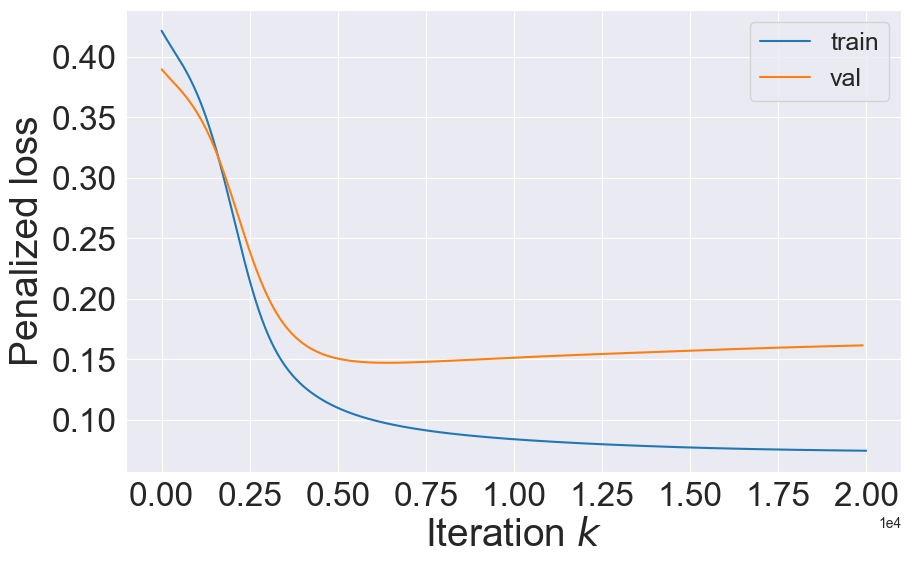

In [111]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses)), penalized_train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

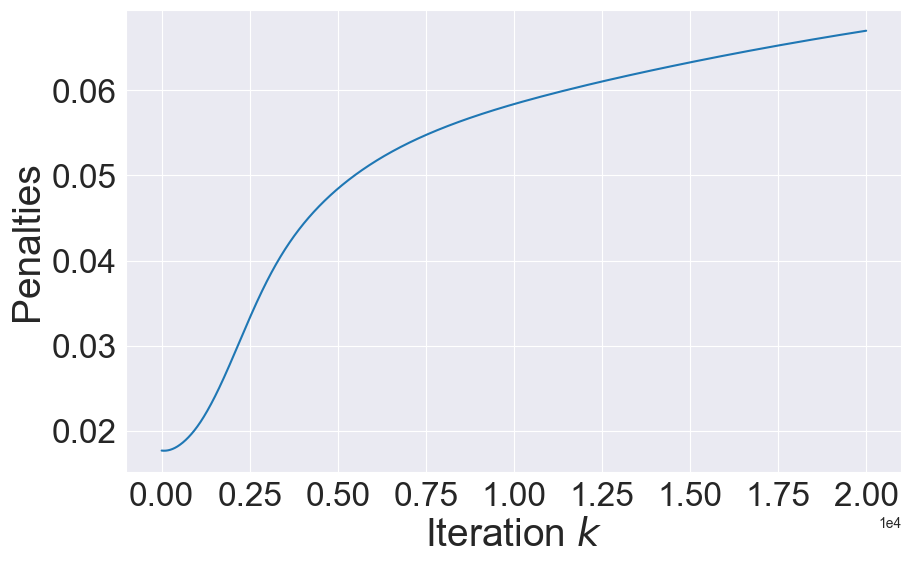

In [109]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses - train_losses

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

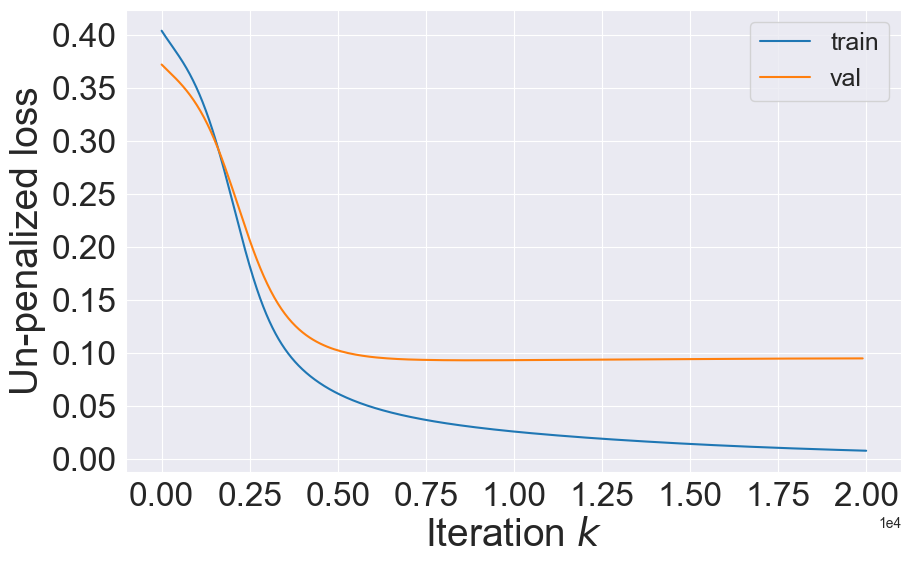

In [110]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 1. Standard conic descent: gradient descent on the empirical loss

In [28]:
n_steps = N_STEPS
m = 500
ETA = 0.01

In [29]:
def conic_particle_update(a, b, x, y):
    m = a.shape[1]
    if m > 0:
        a = a - ETA * V_grad(a, b, x, y, b).reshape(1, -1) / m
        b = b - ETA * nabla_V_grad(a, b, x, y)
    return a, b  

In [87]:
def train(m, n_steps, x_train, y_train, x_val, y_val, do_val=True):
    #a = np.zeros(shape=(1, m))
    a = np.random.normal(size=(1, m)) / m
    b = np.random.normal(size=(m, INPUT_DIM))
    b_norms = np.linalg.norm(b, axis=1, ord=2, keepdims=True)
    b = b / b_norms
    
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []
    ms = [m]

    for k in tqdm(range(n_steps)):
        a, b = conic_particle_update(a, b, x_train, y_train)
        ms.append(a.shape[1])
        
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses) 

In [88]:
a, b, ms, train_losses, penalized_train_losses, val_losses, penalized_val_losses = \
    train(m, n_steps, x_train, y_train, x_val, y_val)

  0%|                                                        | 30/20000 [00:00<02:09, 153.84it/s]

m at step 0 : 500
Train loss at step 0 : 0.40402
Validation loss at step 0 : 0.37302


  1%|▎                                                      | 122/20000 [00:00<02:11, 151.59it/s]

m at step 100 : 500
Train loss at step 100 : 0.39971
Validation loss at step 100 : 0.37022


  1%|▌                                                      | 218/20000 [00:01<02:24, 137.13it/s]

m at step 200 : 500
Train loss at step 200 : 0.39559
Validation loss at step 200 : 0.36748


  2%|▉                                                      | 336/20000 [00:02<01:49, 179.60it/s]

m at step 300 : 500
Train loss at step 300 : 0.39152
Validation loss at step 300 : 0.36473


  2%|█▏                                                     | 439/20000 [00:02<01:40, 193.94it/s]

m at step 400 : 500
Train loss at step 400 : 0.38745
Validation loss at step 400 : 0.36196


  3%|█▍                                                     | 525/20000 [00:03<02:31, 128.20it/s]

m at step 500 : 500
Train loss at step 500 : 0.38326
Validation loss at step 500 : 0.35909


  3%|█▊                                                     | 638/20000 [00:04<01:50, 175.19it/s]

m at step 600 : 500
Train loss at step 600 : 0.37885
Validation loss at step 600 : 0.35607


  4%|██                                                     | 731/20000 [00:04<01:52, 171.00it/s]

m at step 700 : 500
Train loss at step 700 : 0.37415
Validation loss at step 700 : 0.35285


  4%|██▏                                                    | 818/20000 [00:05<02:40, 119.16it/s]

m at step 800 : 500
Train loss at step 800 : 0.36910
Validation loss at step 800 : 0.34939


  5%|██▌                                                    | 924/20000 [00:06<02:03, 154.33it/s]

m at step 900 : 500
Train loss at step 900 : 0.36363
Validation loss at step 900 : 0.34565


  5%|██▋                                                   | 1016/20000 [00:07<02:40, 118.15it/s]

m at step 1,000 : 500
Train loss at step 1,000 : 0.35767
Validation loss at step 1,000 : 0.34159


  6%|███                                                   | 1118/20000 [00:07<02:14, 140.34it/s]

m at step 1,100 : 500
Train loss at step 1,100 : 0.35117
Validation loss at step 1,100 : 0.33713


  6%|███▎                                                  | 1217/20000 [00:08<02:19, 135.06it/s]

m at step 1,200 : 500
Train loss at step 1,200 : 0.34406
Validation loss at step 1,200 : 0.33223


  7%|███▌                                                  | 1326/20000 [00:09<02:25, 127.97it/s]

m at step 1,300 : 500
Train loss at step 1,300 : 0.33627
Validation loss at step 1,300 : 0.32683


  7%|███▊                                                  | 1435/20000 [00:10<01:47, 172.13it/s]

m at step 1,400 : 500
Train loss at step 1,400 : 0.32779
Validation loss at step 1,400 : 0.32093


  8%|████                                                  | 1506/20000 [00:10<01:53, 162.42it/s]

m at step 1,500 : 500
Train loss at step 1,500 : 0.31858
Validation loss at step 1,500 : 0.31448


  8%|████▍                                                 | 1635/20000 [00:11<02:02, 149.34it/s]

m at step 1,600 : 500
Train loss at step 1,600 : 0.30866
Validation loss at step 1,600 : 0.30749


  9%|████▋                                                 | 1739/20000 [00:12<01:34, 192.95it/s]

m at step 1,700 : 500
Train loss at step 1,700 : 0.29802
Validation loss at step 1,700 : 0.29996


  9%|████▉                                                 | 1820/20000 [00:12<01:40, 180.84it/s]

m at step 1,800 : 500
Train loss at step 1,800 : 0.28674
Validation loss at step 1,800 : 0.29191


 10%|█████▏                                                | 1926/20000 [00:13<01:43, 174.66it/s]

m at step 1,900 : 500
Train loss at step 1,900 : 0.27488
Validation loss at step 1,900 : 0.28338


 10%|█████▌                                                | 2039/20000 [00:14<01:24, 212.30it/s]

m at step 2,000 : 500
Train loss at step 2,000 : 0.26255
Validation loss at step 2,000 : 0.27442


 11%|█████▊                                                | 2130/20000 [00:14<01:21, 218.80it/s]

m at step 2,100 : 500
Train loss at step 2,100 : 0.24989
Validation loss at step 2,100 : 0.26509


 11%|██████                                                | 2223/20000 [00:15<02:19, 127.79it/s]

m at step 2,200 : 500
Train loss at step 2,200 : 0.23705
Validation loss at step 2,200 : 0.25549


 12%|██████▎                                               | 2339/20000 [00:16<01:30, 194.22it/s]

m at step 2,300 : 500
Train loss at step 2,300 : 0.22419
Validation loss at step 2,300 : 0.24573


 12%|██████▌                                               | 2422/20000 [00:16<01:33, 187.35it/s]

m at step 2,400 : 500
Train loss at step 2,400 : 0.21148
Validation loss at step 2,400 : 0.23593


 13%|██████▊                                               | 2501/20000 [00:16<01:30, 194.04it/s]

m at step 2,500 : 500
Train loss at step 2,500 : 0.19910
Validation loss at step 2,500 : 0.22619


 13%|███████▏                                              | 2639/20000 [00:17<01:33, 184.86it/s]

m at step 2,600 : 500
Train loss at step 2,600 : 0.18717
Validation loss at step 2,600 : 0.21662


 14%|███████▎                                              | 2718/20000 [00:18<01:46, 162.81it/s]

m at step 2,700 : 500
Train loss at step 2,700 : 0.17584
Validation loss at step 2,700 : 0.20732


 14%|███████▌                                              | 2816/20000 [00:18<01:58, 145.44it/s]

m at step 2,800 : 500
Train loss at step 2,800 : 0.16517
Validation loss at step 2,800 : 0.19837


 15%|███████▉                                              | 2930/20000 [00:19<01:38, 173.61it/s]

m at step 2,900 : 500
Train loss at step 2,900 : 0.15525
Validation loss at step 2,900 : 0.18986


 15%|████████▏                                             | 3032/20000 [00:20<01:26, 195.65it/s]

m at step 3,000 : 500
Train loss at step 3,000 : 0.14609
Validation loss at step 3,000 : 0.18183


 16%|████████▍                                             | 3133/20000 [00:20<01:30, 186.90it/s]

m at step 3,100 : 500
Train loss at step 3,100 : 0.13769
Validation loss at step 3,100 : 0.17432


 16%|████████▋                                             | 3232/20000 [00:21<01:33, 180.23it/s]

m at step 3,200 : 500
Train loss at step 3,200 : 0.13004
Validation loss at step 3,200 : 0.16732


 17%|█████████                                             | 3344/20000 [00:21<01:19, 210.75it/s]

m at step 3,300 : 500
Train loss at step 3,300 : 0.12307
Validation loss at step 3,300 : 0.16085


 17%|█████████▎                                            | 3436/20000 [00:22<01:13, 224.34it/s]

m at step 3,400 : 500
Train loss at step 3,400 : 0.11675
Validation loss at step 3,400 : 0.15487


 18%|█████████▌                                            | 3529/20000 [00:22<01:15, 218.03it/s]

m at step 3,500 : 500
Train loss at step 3,500 : 0.11102
Validation loss at step 3,500 : 0.14940


 18%|█████████▊                                            | 3624/20000 [00:23<01:59, 137.07it/s]

m at step 3,600 : 500
Train loss at step 3,600 : 0.10582
Validation loss at step 3,600 : 0.14441


 19%|██████████                                            | 3725/20000 [00:24<01:54, 142.69it/s]

m at step 3,700 : 500
Train loss at step 3,700 : 0.10109
Validation loss at step 3,700 : 0.13985


 19%|██████████▎                                           | 3817/20000 [00:24<01:55, 140.10it/s]

m at step 3,800 : 500
Train loss at step 3,800 : 0.09678
Validation loss at step 3,800 : 0.13571


 20%|██████████▋                                           | 3936/20000 [00:25<01:40, 159.20it/s]

m at step 3,900 : 500
Train loss at step 3,900 : 0.09285
Validation loss at step 3,900 : 0.13195


 20%|██████████▉                                           | 4033/20000 [00:26<01:31, 175.14it/s]

m at step 4,000 : 500
Train loss at step 4,000 : 0.08924
Validation loss at step 4,000 : 0.12853


 21%|███████████                                           | 4120/20000 [00:26<01:39, 160.02it/s]

m at step 4,100 : 500
Train loss at step 4,100 : 0.08591
Validation loss at step 4,100 : 0.12542


 21%|███████████▍                                          | 4234/20000 [00:27<01:30, 174.40it/s]

m at step 4,200 : 500
Train loss at step 4,200 : 0.08283
Validation loss at step 4,200 : 0.12259


 22%|███████████▋                                          | 4343/20000 [00:28<01:13, 213.23it/s]

m at step 4,300 : 500
Train loss at step 4,300 : 0.07996
Validation loss at step 4,300 : 0.12001


 22%|███████████▉                                          | 4427/20000 [00:28<01:32, 168.84it/s]

m at step 4,400 : 500
Train loss at step 4,400 : 0.07729
Validation loss at step 4,400 : 0.11767


 23%|████████████▏                                         | 4524/20000 [00:29<01:55, 134.01it/s]

m at step 4,500 : 500
Train loss at step 4,500 : 0.07479
Validation loss at step 4,500 : 0.11553


 23%|████████████▍                                         | 4623/20000 [00:29<01:43, 148.21it/s]

m at step 4,600 : 500
Train loss at step 4,600 : 0.07245
Validation loss at step 4,600 : 0.11358


 24%|████████████▊                                         | 4741/20000 [00:30<01:08, 221.33it/s]

m at step 4,700 : 500
Train loss at step 4,700 : 0.07025
Validation loss at step 4,700 : 0.11181


 24%|████████████▉                                         | 4809/20000 [00:30<01:12, 209.72it/s]

m at step 4,800 : 500
Train loss at step 4,800 : 0.06819
Validation loss at step 4,800 : 0.11020


 25%|█████████████▎                                        | 4933/20000 [00:31<01:24, 177.68it/s]

m at step 4,900 : 500
Train loss at step 4,900 : 0.06624
Validation loss at step 4,900 : 0.10873


 25%|█████████████▌                                        | 5026/20000 [00:32<01:26, 174.05it/s]

m at step 5,000 : 500
Train loss at step 5,000 : 0.06440
Validation loss at step 5,000 : 0.10739


 26%|█████████████▊                                        | 5129/20000 [00:32<01:29, 166.20it/s]

m at step 5,100 : 500
Train loss at step 5,100 : 0.06265
Validation loss at step 5,100 : 0.10616


 26%|██████████████                                        | 5229/20000 [00:33<01:42, 144.10it/s]

m at step 5,200 : 500
Train loss at step 5,200 : 0.06099
Validation loss at step 5,200 : 0.10503


 27%|██████████████▍                                       | 5327/20000 [00:34<01:18, 186.77it/s]

m at step 5,300 : 500
Train loss at step 5,300 : 0.05941
Validation loss at step 5,300 : 0.10401


 27%|██████████████▋                                       | 5422/20000 [00:34<01:31, 159.86it/s]

m at step 5,400 : 500
Train loss at step 5,400 : 0.05791
Validation loss at step 5,400 : 0.10307


 28%|██████████████▉                                       | 5533/20000 [00:35<01:36, 149.82it/s]

m at step 5,500 : 500
Train loss at step 5,500 : 0.05648
Validation loss at step 5,500 : 0.10222


 28%|███████████████▏                                      | 5630/20000 [00:36<01:31, 156.93it/s]

m at step 5,600 : 500
Train loss at step 5,600 : 0.05512
Validation loss at step 5,600 : 0.10144


 29%|███████████████▍                                      | 5711/20000 [00:36<01:42, 139.79it/s]

m at step 5,700 : 500
Train loss at step 5,700 : 0.05382
Validation loss at step 5,700 : 0.10074


 29%|███████████████▋                                      | 5808/20000 [00:37<02:07, 111.34it/s]

m at step 5,800 : 500
Train loss at step 5,800 : 0.05258
Validation loss at step 5,800 : 0.10011


 30%|████████████████                                      | 5930/20000 [00:38<01:12, 195.29it/s]

m at step 5,900 : 500
Train loss at step 5,900 : 0.05139
Validation loss at step 5,900 : 0.09954


 30%|████████████████▏                                     | 6014/20000 [00:38<01:12, 192.63it/s]

m at step 6,000 : 500
Train loss at step 6,000 : 0.05025
Validation loss at step 6,000 : 0.09902


 31%|████████████████▍                                     | 6104/20000 [00:39<01:27, 158.49it/s]

m at step 6,100 : 500
Train loss at step 6,100 : 0.04916
Validation loss at step 6,100 : 0.09856


 31%|████████████████▊                                     | 6238/20000 [00:40<01:16, 180.96it/s]

m at step 6,200 : 500
Train loss at step 6,200 : 0.04811
Validation loss at step 6,200 : 0.09813


 32%|█████████████████                                     | 6308/20000 [00:40<01:33, 145.79it/s]

m at step 6,300 : 500
Train loss at step 6,300 : 0.04711
Validation loss at step 6,300 : 0.09774


 32%|█████████████████▎                                    | 6424/20000 [00:41<01:21, 166.94it/s]

m at step 6,400 : 500
Train loss at step 6,400 : 0.04615
Validation loss at step 6,400 : 0.09739


 33%|█████████████████▌                                    | 6523/20000 [00:42<01:13, 182.13it/s]

m at step 6,500 : 500
Train loss at step 6,500 : 0.04523
Validation loss at step 6,500 : 0.09707


 33%|█████████████████▉                                    | 6625/20000 [00:42<01:33, 143.12it/s]

m at step 6,600 : 500
Train loss at step 6,600 : 0.04434
Validation loss at step 6,600 : 0.09677


 34%|██████████████████▏                                   | 6727/20000 [00:43<01:13, 180.15it/s]

m at step 6,700 : 500
Train loss at step 6,700 : 0.04349
Validation loss at step 6,700 : 0.09651


 34%|██████████████████▍                                   | 6836/20000 [00:44<01:04, 203.11it/s]

m at step 6,800 : 500
Train loss at step 6,800 : 0.04267
Validation loss at step 6,800 : 0.09628


 35%|██████████████████▋                                   | 6922/20000 [00:44<01:19, 163.92it/s]

m at step 6,900 : 500
Train loss at step 6,900 : 0.04188
Validation loss at step 6,900 : 0.09607


 35%|██████████████████▉                                   | 7028/20000 [00:45<01:19, 163.91it/s]

m at step 7,000 : 500
Train loss at step 7,000 : 0.04112
Validation loss at step 7,000 : 0.09589


 36%|███████████████████▎                                  | 7136/20000 [00:45<01:01, 209.76it/s]

m at step 7,100 : 500
Train loss at step 7,100 : 0.04038
Validation loss at step 7,100 : 0.09572


 36%|███████████████████▌                                  | 7231/20000 [00:46<00:55, 230.24it/s]

m at step 7,200 : 500
Train loss at step 7,200 : 0.03967
Validation loss at step 7,200 : 0.09557


 37%|███████████████████▊                                  | 7324/20000 [00:46<00:58, 215.13it/s]

m at step 7,300 : 500
Train loss at step 7,300 : 0.03899
Validation loss at step 7,300 : 0.09544


 37%|████████████████████                                  | 7440/20000 [00:47<01:08, 184.48it/s]

m at step 7,400 : 500
Train loss at step 7,400 : 0.03832
Validation loss at step 7,400 : 0.09532


 38%|████████████████████▎                                 | 7534/20000 [00:48<00:57, 216.32it/s]

m at step 7,500 : 500
Train loss at step 7,500 : 0.03768
Validation loss at step 7,500 : 0.09522


 38%|████████████████████▌                                 | 7630/20000 [00:48<00:53, 230.35it/s]

m at step 7,600 : 500
Train loss at step 7,600 : 0.03706
Validation loss at step 7,600 : 0.09513


 39%|████████████████████▊                                 | 7718/20000 [00:49<01:22, 148.96it/s]

m at step 7,700 : 500
Train loss at step 7,700 : 0.03646
Validation loss at step 7,700 : 0.09505


 39%|█████████████████████                                 | 7820/20000 [00:49<01:20, 151.92it/s]

m at step 7,800 : 500
Train loss at step 7,800 : 0.03587
Validation loss at step 7,800 : 0.09498


 40%|█████████████████████▍                                | 7924/20000 [00:50<01:03, 189.57it/s]

m at step 7,900 : 500
Train loss at step 7,900 : 0.03531
Validation loss at step 7,900 : 0.09492


 40%|█████████████████████▋                                | 8022/20000 [00:50<01:07, 178.72it/s]

m at step 8,000 : 500
Train loss at step 8,000 : 0.03475
Validation loss at step 8,000 : 0.09487


 41%|█████████████████████▉                                | 8140/20000 [00:51<01:04, 184.00it/s]

m at step 8,100 : 500
Train loss at step 8,100 : 0.03422
Validation loss at step 8,100 : 0.09482


 41%|██████████████████████▏                               | 8222/20000 [00:52<01:04, 182.04it/s]

m at step 8,200 : 500
Train loss at step 8,200 : 0.03369
Validation loss at step 8,200 : 0.09478


 42%|██████████████████████▍                               | 8325/20000 [00:52<01:00, 194.02it/s]

m at step 8,300 : 500
Train loss at step 8,300 : 0.03319
Validation loss at step 8,300 : 0.09474


 42%|██████████████████████▊                               | 8426/20000 [00:53<01:41, 113.51it/s]

m at step 8,400 : 500
Train loss at step 8,400 : 0.03269
Validation loss at step 8,400 : 0.09471


 43%|███████████████████████                               | 8533/20000 [00:54<01:02, 182.28it/s]

m at step 8,500 : 500
Train loss at step 8,500 : 0.03221
Validation loss at step 8,500 : 0.09469


 43%|███████████████████████▎                              | 8641/20000 [00:54<00:56, 201.00it/s]

m at step 8,600 : 500
Train loss at step 8,600 : 0.03174
Validation loss at step 8,600 : 0.09467


 44%|███████████████████████▌                              | 8748/20000 [00:55<00:58, 193.82it/s]

m at step 8,700 : 500
Train loss at step 8,700 : 0.03128
Validation loss at step 8,700 : 0.09465


 44%|███████████████████████▊                              | 8836/20000 [00:55<00:53, 208.56it/s]

m at step 8,800 : 500
Train loss at step 8,800 : 0.03083
Validation loss at step 8,800 : 0.09464


 45%|████████████████████████                              | 8919/20000 [00:56<01:03, 173.91it/s]

m at step 8,900 : 500
Train loss at step 8,900 : 0.03039
Validation loss at step 8,900 : 0.09463


 45%|████████████████████████▎                             | 9021/20000 [00:56<01:03, 172.17it/s]

m at step 9,000 : 500
Train loss at step 9,000 : 0.02997
Validation loss at step 9,000 : 0.09463


 46%|████████████████████████▋                             | 9127/20000 [00:57<00:56, 193.00it/s]

m at step 9,100 : 500
Train loss at step 9,100 : 0.02955
Validation loss at step 9,100 : 0.09463


 46%|████████████████████████▉                             | 9240/20000 [00:58<00:49, 218.61it/s]

m at step 9,200 : 500
Train loss at step 9,200 : 0.02914
Validation loss at step 9,200 : 0.09462


 47%|█████████████████████████▏                            | 9329/20000 [00:58<00:52, 201.61it/s]

m at step 9,300 : 500
Train loss at step 9,300 : 0.02874
Validation loss at step 9,300 : 0.09462


 47%|█████████████████████████▍                            | 9428/20000 [00:59<01:11, 148.21it/s]

m at step 9,400 : 500
Train loss at step 9,400 : 0.02835
Validation loss at step 9,400 : 0.09462


 48%|█████████████████████████▋                            | 9528/20000 [00:59<01:08, 153.02it/s]

m at step 9,500 : 500
Train loss at step 9,500 : 0.02797
Validation loss at step 9,500 : 0.09462


 48%|█████████████████████████▉                            | 9622/20000 [01:00<01:04, 159.66it/s]

m at step 9,600 : 500
Train loss at step 9,600 : 0.02760
Validation loss at step 9,600 : 0.09462


 49%|██████████████████████████▎                           | 9731/20000 [01:01<01:17, 133.03it/s]

m at step 9,700 : 500
Train loss at step 9,700 : 0.02723
Validation loss at step 9,700 : 0.09463


 49%|██████████████████████████▌                           | 9825/20000 [01:01<01:02, 163.49it/s]

m at step 9,800 : 500
Train loss at step 9,800 : 0.02687
Validation loss at step 9,800 : 0.09463


 50%|██████████████████████████▊                           | 9935/20000 [01:02<00:56, 179.47it/s]

m at step 9,900 : 500
Train loss at step 9,900 : 0.02652
Validation loss at step 9,900 : 0.09463


 50%|██████████████████████████▌                          | 10017/20000 [01:03<01:20, 123.98it/s]

m at step 10,000 : 500
Train loss at step 10,000 : 0.02617
Validation loss at step 10,000 : 0.09464


 51%|██████████████████████████▊                          | 10125/20000 [01:03<00:58, 168.79it/s]

m at step 10,100 : 500
Train loss at step 10,100 : 0.02583
Validation loss at step 10,100 : 0.09464


 51%|███████████████████████████                          | 10233/20000 [01:04<00:49, 198.76it/s]

m at step 10,200 : 500
Train loss at step 10,200 : 0.02549
Validation loss at step 10,200 : 0.09465


 52%|███████████████████████████▎                         | 10321/20000 [01:04<00:47, 202.78it/s]

m at step 10,300 : 500
Train loss at step 10,300 : 0.02516
Validation loss at step 10,300 : 0.09466


 52%|███████████████████████████▋                         | 10427/20000 [01:05<00:49, 192.35it/s]

m at step 10,400 : 500
Train loss at step 10,400 : 0.02484
Validation loss at step 10,400 : 0.09467


 53%|███████████████████████████▉                         | 10541/20000 [01:06<00:43, 215.93it/s]

m at step 10,500 : 500
Train loss at step 10,500 : 0.02452
Validation loss at step 10,500 : 0.09468


 53%|████████████████████████████▏                        | 10634/20000 [01:06<00:41, 224.43it/s]

m at step 10,600 : 500
Train loss at step 10,600 : 0.02421
Validation loss at step 10,600 : 0.09470


 54%|████████████████████████████▍                        | 10726/20000 [01:06<00:45, 205.47it/s]

m at step 10,700 : 500
Train loss at step 10,700 : 0.02390
Validation loss at step 10,700 : 0.09471


 54%|████████████████████████████▋                        | 10816/20000 [01:07<01:01, 148.31it/s]

m at step 10,800 : 500
Train loss at step 10,800 : 0.02360
Validation loss at step 10,800 : 0.09472


 55%|████████████████████████████▉                        | 10927/20000 [01:08<00:46, 195.92it/s]

m at step 10,900 : 500
Train loss at step 10,900 : 0.02330
Validation loss at step 10,900 : 0.09474


 55%|█████████████████████████████▏                       | 11034/20000 [01:08<00:46, 194.34it/s]

m at step 11,000 : 500
Train loss at step 11,000 : 0.02301
Validation loss at step 11,000 : 0.09475


 56%|█████████████████████████████▍                       | 11124/20000 [01:09<01:06, 134.41it/s]

m at step 11,100 : 500
Train loss at step 11,100 : 0.02272
Validation loss at step 11,100 : 0.09476


 56%|█████████████████████████████▋                       | 11226/20000 [01:10<00:55, 157.09it/s]

m at step 11,200 : 500
Train loss at step 11,200 : 0.02244
Validation loss at step 11,200 : 0.09478


 57%|██████████████████████████████                       | 11325/20000 [01:10<00:44, 193.62it/s]

m at step 11,300 : 500
Train loss at step 11,300 : 0.02217
Validation loss at step 11,300 : 0.09479


 57%|██████████████████████████████▎                      | 11443/20000 [01:11<00:49, 173.17it/s]

m at step 11,400 : 500
Train loss at step 11,400 : 0.02189
Validation loss at step 11,400 : 0.09481


 58%|██████████████████████████████▌                      | 11531/20000 [01:11<00:42, 200.35it/s]

m at step 11,500 : 500
Train loss at step 11,500 : 0.02163
Validation loss at step 11,500 : 0.09482


 58%|██████████████████████████████▊                      | 11625/20000 [01:12<00:37, 226.06it/s]

m at step 11,600 : 500
Train loss at step 11,600 : 0.02136
Validation loss at step 11,600 : 0.09484


 59%|███████████████████████████████                      | 11721/20000 [01:12<00:36, 226.47it/s]

m at step 11,700 : 500
Train loss at step 11,700 : 0.02110
Validation loss at step 11,700 : 0.09485


 59%|███████████████████████████████▎                     | 11830/20000 [01:13<00:48, 167.53it/s]

m at step 11,800 : 500
Train loss at step 11,800 : 0.02084
Validation loss at step 11,800 : 0.09486


 60%|███████████████████████████████▌                     | 11921/20000 [01:13<00:40, 198.94it/s]

m at step 11,900 : 500
Train loss at step 11,900 : 0.02059
Validation loss at step 11,900 : 0.09487


 60%|███████████████████████████████▉                     | 12037/20000 [01:14<00:35, 223.68it/s]

m at step 12,000 : 500
Train loss at step 12,000 : 0.02034
Validation loss at step 12,000 : 0.09488


 61%|████████████████████████████████▏                    | 12130/20000 [01:14<00:35, 219.07it/s]

m at step 12,100 : 500
Train loss at step 12,100 : 0.02009
Validation loss at step 12,100 : 0.09489


 61%|████████████████████████████████▍                    | 12233/20000 [01:15<00:45, 171.71it/s]

m at step 12,200 : 500
Train loss at step 12,200 : 0.01985
Validation loss at step 12,200 : 0.09489


 62%|████████████████████████████████▋                    | 12321/20000 [01:15<00:39, 196.51it/s]

m at step 12,300 : 500
Train loss at step 12,300 : 0.01961
Validation loss at step 12,300 : 0.09490


 62%|████████████████████████████████▉                    | 12438/20000 [01:16<00:33, 226.92it/s]

m at step 12,400 : 500
Train loss at step 12,400 : 0.01937
Validation loss at step 12,400 : 0.09491


 63%|█████████████████████████████████▏                   | 12530/20000 [01:16<00:34, 216.01it/s]

m at step 12,500 : 500
Train loss at step 12,500 : 0.01914
Validation loss at step 12,500 : 0.09492


 63%|█████████████████████████████████▍                   | 12634/20000 [01:17<00:42, 173.30it/s]

m at step 12,600 : 500
Train loss at step 12,600 : 0.01892
Validation loss at step 12,600 : 0.09492


 64%|█████████████████████████████████▋                   | 12723/20000 [01:17<00:36, 199.45it/s]

m at step 12,700 : 500
Train loss at step 12,700 : 0.01869
Validation loss at step 12,700 : 0.09493


 64%|██████████████████████████████████                   | 12837/20000 [01:18<00:32, 221.61it/s]

m at step 12,800 : 500
Train loss at step 12,800 : 0.01847
Validation loss at step 12,800 : 0.09493


 65%|██████████████████████████████████▎                  | 12930/20000 [01:18<00:32, 217.99it/s]

m at step 12,900 : 500
Train loss at step 12,900 : 0.01825
Validation loss at step 12,900 : 0.09494


 65%|██████████████████████████████████▌                  | 13032/20000 [01:19<00:40, 173.15it/s]

m at step 13,000 : 500
Train loss at step 13,000 : 0.01803
Validation loss at step 13,000 : 0.09494


 66%|██████████████████████████████████▊                  | 13141/20000 [01:20<00:33, 203.31it/s]

m at step 13,100 : 500
Train loss at step 13,100 : 0.01782
Validation loss at step 13,100 : 0.09495


 66%|███████████████████████████████████                  | 13234/20000 [01:20<00:30, 223.65it/s]

m at step 13,200 : 500
Train loss at step 13,200 : 0.01761
Validation loss at step 13,200 : 0.09496


 67%|███████████████████████████████████▎                 | 13328/20000 [01:20<00:31, 215.03it/s]

m at step 13,300 : 500
Train loss at step 13,300 : 0.01740
Validation loss at step 13,300 : 0.09496


 67%|███████████████████████████████████▌                 | 13434/20000 [01:21<00:36, 178.14it/s]

m at step 13,400 : 500
Train loss at step 13,400 : 0.01719
Validation loss at step 13,400 : 0.09497


 68%|███████████████████████████████████▊                 | 13522/20000 [01:21<00:32, 201.41it/s]

m at step 13,500 : 500
Train loss at step 13,500 : 0.01699
Validation loss at step 13,500 : 0.09498


 68%|████████████████████████████████████▏                | 13640/20000 [01:22<00:27, 227.96it/s]

m at step 13,600 : 500
Train loss at step 13,600 : 0.01679
Validation loss at step 13,600 : 0.09498


 69%|████████████████████████████████████▍                | 13734/20000 [01:22<00:29, 213.88it/s]

m at step 13,700 : 500
Train loss at step 13,700 : 0.01659
Validation loss at step 13,700 : 0.09498


 69%|████████████████████████████████████▋                | 13840/20000 [01:23<00:33, 181.22it/s]

m at step 13,800 : 500
Train loss at step 13,800 : 0.01639
Validation loss at step 13,800 : 0.09498


 70%|████████████████████████████████████▉                | 13926/20000 [01:23<00:30, 199.48it/s]

m at step 13,900 : 500
Train loss at step 13,900 : 0.01620
Validation loss at step 13,900 : 0.09499


 70%|█████████████████████████████████████▏               | 14044/20000 [01:24<00:27, 217.13it/s]

m at step 14,000 : 500
Train loss at step 14,000 : 0.01601
Validation loss at step 14,000 : 0.09499


 71%|█████████████████████████████████████▍               | 14134/20000 [01:24<00:29, 200.46it/s]

m at step 14,100 : 500
Train loss at step 14,100 : 0.01582
Validation loss at step 14,100 : 0.09500


 71%|█████████████████████████████████████▋               | 14236/20000 [01:25<00:32, 177.38it/s]

m at step 14,200 : 500
Train loss at step 14,200 : 0.01563
Validation loss at step 14,200 : 0.09501


 72%|██████████████████████████████████████               | 14342/20000 [01:26<00:27, 204.96it/s]

m at step 14,300 : 500
Train loss at step 14,300 : 0.01545
Validation loss at step 14,300 : 0.09501


 72%|██████████████████████████████████████▏              | 14433/20000 [01:26<00:27, 204.47it/s]

m at step 14,400 : 500
Train loss at step 14,400 : 0.01526
Validation loss at step 14,400 : 0.09502


 73%|██████████████████████████████████████▌              | 14541/20000 [01:27<00:26, 203.81it/s]

m at step 14,500 : 500
Train loss at step 14,500 : 0.01508
Validation loss at step 14,500 : 0.09503


 73%|██████████████████████████████████████▊              | 14627/20000 [01:27<00:28, 186.86it/s]

m at step 14,600 : 500
Train loss at step 14,600 : 0.01490
Validation loss at step 14,600 : 0.09503


 74%|███████████████████████████████████████              | 14739/20000 [01:28<00:24, 214.23it/s]

m at step 14,700 : 500
Train loss at step 14,700 : 0.01473
Validation loss at step 14,700 : 0.09503


 74%|███████████████████████████████████████▎             | 14832/20000 [01:28<00:22, 226.37it/s]

m at step 14,800 : 500
Train loss at step 14,800 : 0.01456
Validation loss at step 14,800 : 0.09503


 75%|███████████████████████████████████████▌             | 14923/20000 [01:28<00:23, 213.14it/s]

m at step 14,900 : 500
Train loss at step 14,900 : 0.01438
Validation loss at step 14,900 : 0.09504


 75%|███████████████████████████████████████▊             | 15027/20000 [01:29<00:27, 179.37it/s]

m at step 15,000 : 500
Train loss at step 15,000 : 0.01421
Validation loss at step 15,000 : 0.09504


 76%|████████████████████████████████████████             | 15134/20000 [01:30<00:23, 206.24it/s]

m at step 15,100 : 500
Train loss at step 15,100 : 0.01404
Validation loss at step 15,100 : 0.09504


 76%|████████████████████████████████████████▎            | 15227/20000 [01:30<00:21, 225.10it/s]

m at step 15,200 : 500
Train loss at step 15,200 : 0.01388
Validation loss at step 15,200 : 0.09504


 77%|████████████████████████████████████████▋            | 15341/20000 [01:31<00:22, 206.12it/s]

m at step 15,300 : 500
Train loss at step 15,300 : 0.01371
Validation loss at step 15,300 : 0.09504


 77%|████████████████████████████████████████▉            | 15428/20000 [01:31<00:23, 191.05it/s]

m at step 15,400 : 500
Train loss at step 15,400 : 0.01355
Validation loss at step 15,400 : 0.09505


 78%|█████████████████████████████████████████▏           | 15531/20000 [01:32<00:23, 192.73it/s]

m at step 15,500 : 500
Train loss at step 15,500 : 0.01339
Validation loss at step 15,500 : 0.09505


 78%|█████████████████████████████████████████▍           | 15623/20000 [01:32<00:30, 142.03it/s]

m at step 15,600 : 500
Train loss at step 15,600 : 0.01323
Validation loss at step 15,600 : 0.09505


 79%|█████████████████████████████████████████▋           | 15733/20000 [01:33<00:29, 146.79it/s]

m at step 15,700 : 500
Train loss at step 15,700 : 0.01307
Validation loss at step 15,700 : 0.09506


 79%|█████████████████████████████████████████▉           | 15842/20000 [01:34<00:20, 204.04it/s]

m at step 15,800 : 500
Train loss at step 15,800 : 0.01292
Validation loss at step 15,800 : 0.09506


 80%|██████████████████████████████████████████▏          | 15937/20000 [01:34<00:17, 226.82it/s]

m at step 15,900 : 500
Train loss at step 15,900 : 0.01277
Validation loss at step 15,900 : 0.09507


 80%|██████████████████████████████████████████▍          | 16028/20000 [01:34<00:18, 211.48it/s]

m at step 16,000 : 500
Train loss at step 16,000 : 0.01261
Validation loss at step 16,000 : 0.09508


 81%|██████████████████████████████████████████▊          | 16134/20000 [01:35<00:20, 186.52it/s]

m at step 16,100 : 500
Train loss at step 16,100 : 0.01247
Validation loss at step 16,100 : 0.09508


 81%|███████████████████████████████████████████          | 16245/20000 [01:36<00:17, 213.26it/s]

m at step 16,200 : 500
Train loss at step 16,200 : 0.01232
Validation loss at step 16,200 : 0.09509


 82%|███████████████████████████████████████████▎         | 16339/20000 [01:36<00:16, 228.45it/s]

m at step 16,300 : 500
Train loss at step 16,300 : 0.01217
Validation loss at step 16,300 : 0.09509


 82%|███████████████████████████████████████████▌         | 16431/20000 [01:36<00:16, 213.97it/s]

m at step 16,400 : 500
Train loss at step 16,400 : 0.01203
Validation loss at step 16,400 : 0.09510


 83%|███████████████████████████████████████████▊         | 16536/20000 [01:37<00:19, 181.02it/s]

m at step 16,500 : 500
Train loss at step 16,500 : 0.01188
Validation loss at step 16,500 : 0.09510


 83%|████████████████████████████████████████████         | 16643/20000 [01:38<00:16, 205.22it/s]

m at step 16,600 : 500
Train loss at step 16,600 : 0.01174
Validation loss at step 16,600 : 0.09511


 84%|████████████████████████████████████████████▎        | 16735/20000 [01:38<00:15, 216.05it/s]

m at step 16,700 : 500
Train loss at step 16,700 : 0.01160
Validation loss at step 16,700 : 0.09511


 84%|████████████████████████████████████████████▌        | 16823/20000 [01:38<00:15, 207.48it/s]

m at step 16,800 : 500
Train loss at step 16,800 : 0.01146
Validation loss at step 16,800 : 0.09512


 85%|████████████████████████████████████████████▊        | 16921/20000 [01:39<00:19, 160.57it/s]

m at step 16,900 : 500
Train loss at step 16,900 : 0.01132
Validation loss at step 16,900 : 0.09512


 85%|█████████████████████████████████████████████▏       | 17033/20000 [01:40<00:13, 214.88it/s]

m at step 17,000 : 500
Train loss at step 17,000 : 0.01119
Validation loss at step 17,000 : 0.09512


 86%|█████████████████████████████████████████████▍       | 17126/20000 [01:40<00:12, 227.14it/s]

m at step 17,100 : 500
Train loss at step 17,100 : 0.01105
Validation loss at step 17,100 : 0.09513


 86%|█████████████████████████████████████████████▋       | 17218/20000 [01:41<00:13, 204.31it/s]

m at step 17,200 : 500
Train loss at step 17,200 : 0.01092
Validation loss at step 17,200 : 0.09513


 87%|█████████████████████████████████████████████▉       | 17326/20000 [01:41<00:13, 197.29it/s]

m at step 17,300 : 500
Train loss at step 17,300 : 0.01079
Validation loss at step 17,300 : 0.09513


 87%|██████████████████████████████████████████████▏      | 17441/20000 [01:42<00:11, 222.38it/s]

m at step 17,400 : 500
Train loss at step 17,400 : 0.01066
Validation loss at step 17,400 : 0.09514


 88%|██████████████████████████████████████████████▍      | 17536/20000 [01:42<00:10, 229.79it/s]

m at step 17,500 : 500
Train loss at step 17,500 : 0.01053
Validation loss at step 17,500 : 0.09514


 88%|██████████████████████████████████████████████▋      | 17627/20000 [01:43<00:12, 190.22it/s]

m at step 17,600 : 500
Train loss at step 17,600 : 0.01041
Validation loss at step 17,600 : 0.09514


 89%|███████████████████████████████████████████████      | 17736/20000 [01:43<00:11, 203.52it/s]

m at step 17,700 : 500
Train loss at step 17,700 : 0.01028
Validation loss at step 17,700 : 0.09515


 89%|███████████████████████████████████████████████▏     | 17826/20000 [01:44<00:10, 217.17it/s]

m at step 17,800 : 500
Train loss at step 17,800 : 0.01016
Validation loss at step 17,800 : 0.09515


 90%|███████████████████████████████████████████████▌     | 17948/20000 [01:44<00:08, 234.27it/s]

m at step 17,900 : 500
Train loss at step 17,900 : 0.01003
Validation loss at step 17,900 : 0.09515


 90%|███████████████████████████████████████████████▋     | 18017/20000 [01:44<00:09, 216.27it/s]

m at step 18,000 : 500
Train loss at step 18,000 : 0.00991
Validation loss at step 18,000 : 0.09516


 91%|████████████████████████████████████████████████     | 18124/20000 [01:45<00:09, 191.02it/s]

m at step 18,100 : 500
Train loss at step 18,100 : 0.00979
Validation loss at step 18,100 : 0.09516


 91%|████████████████████████████████████████████████▎    | 18239/20000 [01:46<00:08, 219.85it/s]

m at step 18,200 : 500
Train loss at step 18,200 : 0.00967
Validation loss at step 18,200 : 0.09517


 92%|████████████████████████████████████████████████▌    | 18332/20000 [01:46<00:08, 193.36it/s]

m at step 18,300 : 500
Train loss at step 18,300 : 0.00956
Validation loss at step 18,300 : 0.09518


 92%|████████████████████████████████████████████████▊    | 18415/20000 [01:47<00:10, 149.58it/s]

m at step 18,400 : 500
Train loss at step 18,400 : 0.00944
Validation loss at step 18,400 : 0.09519


 93%|█████████████████████████████████████████████████    | 18526/20000 [01:47<00:07, 203.80it/s]

m at step 18,500 : 500
Train loss at step 18,500 : 0.00933
Validation loss at step 18,500 : 0.09520


 93%|█████████████████████████████████████████████████▍   | 18643/20000 [01:48<00:06, 201.06it/s]

m at step 18,600 : 500
Train loss at step 18,600 : 0.00922
Validation loss at step 18,600 : 0.09520


 94%|█████████████████████████████████████████████████▋   | 18732/20000 [01:48<00:06, 192.00it/s]

m at step 18,700 : 500
Train loss at step 18,700 : 0.00910
Validation loss at step 18,700 : 0.09521


 94%|█████████████████████████████████████████████████▉   | 18839/20000 [01:50<00:08, 144.10it/s]

m at step 18,800 : 500
Train loss at step 18,800 : 0.00899
Validation loss at step 18,800 : 0.09521


 95%|██████████████████████████████████████████████████▏  | 18932/20000 [01:50<00:05, 201.48it/s]

m at step 18,900 : 500
Train loss at step 18,900 : 0.00888
Validation loss at step 18,900 : 0.09522


 95%|██████████████████████████████████████████████████▍  | 19022/20000 [01:50<00:04, 198.67it/s]

m at step 19,000 : 500
Train loss at step 19,000 : 0.00878
Validation loss at step 19,000 : 0.09523


 96%|██████████████████████████████████████████████████▋  | 19125/20000 [01:51<00:04, 180.03it/s]

m at step 19,100 : 500
Train loss at step 19,100 : 0.00867
Validation loss at step 19,100 : 0.09524


 96%|██████████████████████████████████████████████████▉  | 19236/20000 [01:52<00:03, 207.56it/s]

m at step 19,200 : 500
Train loss at step 19,200 : 0.00857
Validation loss at step 19,200 : 0.09525


 97%|███████████████████████████████████████████████████▏ | 19324/20000 [01:52<00:03, 209.19it/s]

m at step 19,300 : 500
Train loss at step 19,300 : 0.00846
Validation loss at step 19,300 : 0.09525


 97%|███████████████████████████████████████████████████▍ | 19413/20000 [01:52<00:02, 206.31it/s]

m at step 19,400 : 500
Train loss at step 19,400 : 0.00836
Validation loss at step 19,400 : 0.09526


 98%|███████████████████████████████████████████████████▊ | 19536/20000 [01:53<00:02, 180.66it/s]

m at step 19,500 : 500
Train loss at step 19,500 : 0.00826
Validation loss at step 19,500 : 0.09527


 98%|████████████████████████████████████████████████████ | 19627/20000 [01:54<00:01, 214.79it/s]

m at step 19,600 : 500
Train loss at step 19,600 : 0.00816
Validation loss at step 19,600 : 0.09528


 99%|████████████████████████████████████████████████████▎| 19741/20000 [01:54<00:01, 218.58it/s]

m at step 19,700 : 500
Train loss at step 19,700 : 0.00806
Validation loss at step 19,700 : 0.09529


 99%|████████████████████████████████████████████████████▍| 19805/20000 [01:55<00:01, 182.58it/s]

m at step 19,800 : 500
Train loss at step 19,800 : 0.00796
Validation loss at step 19,800 : 0.09530


100%|████████████████████████████████████████████████████▊| 19931/20000 [01:55<00:00, 192.01it/s]

m at step 19,900 : 500
Train loss at step 19,900 : 0.00786
Validation loss at step 19,900 : 0.09531


100%|█████████████████████████████████████████████████████| 20000/20000 [01:56<00:00, 171.98it/s]


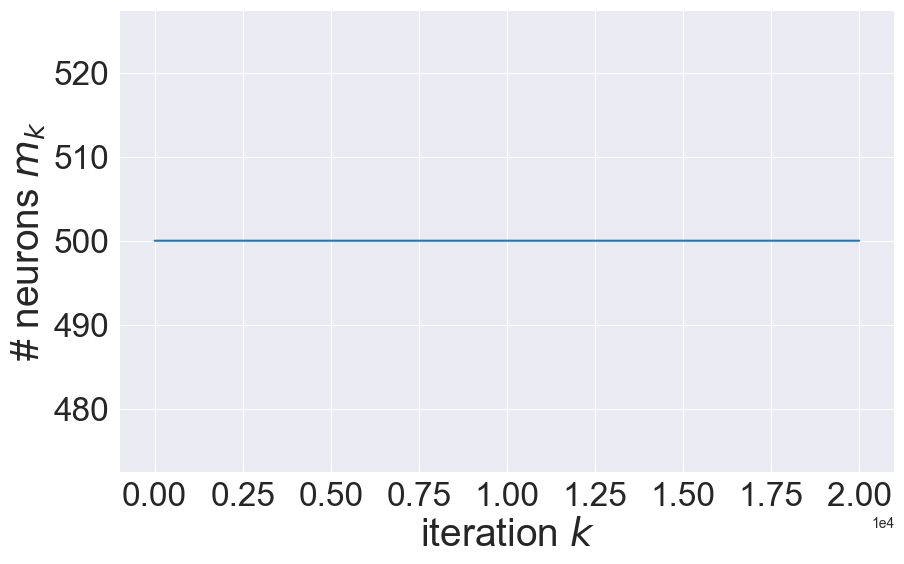

In [89]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms)), ms, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

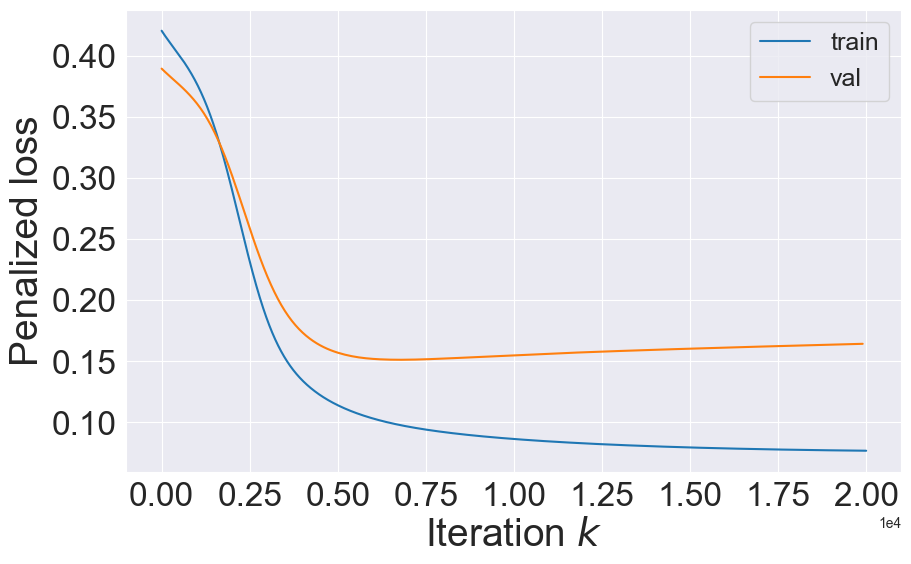

In [90]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses)), penalized_train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

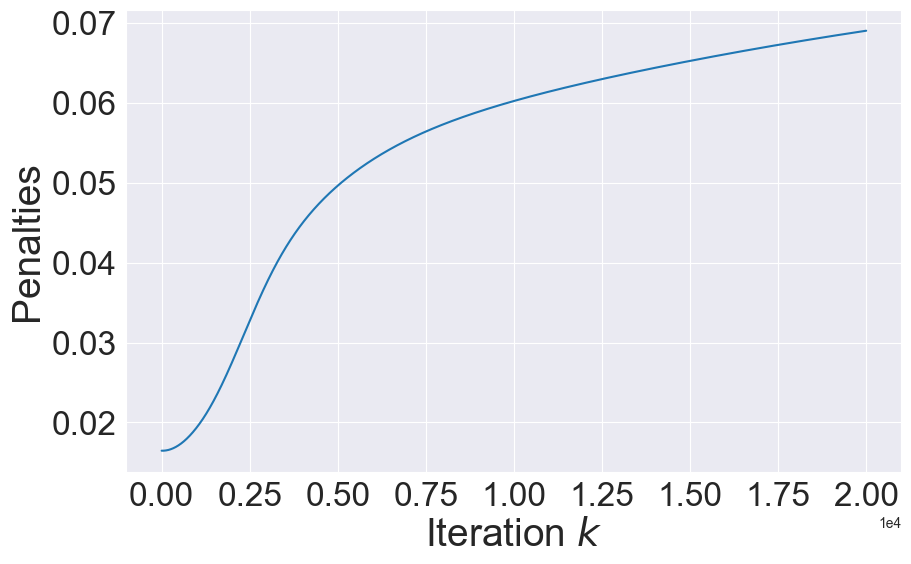

In [91]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses - train_losses

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

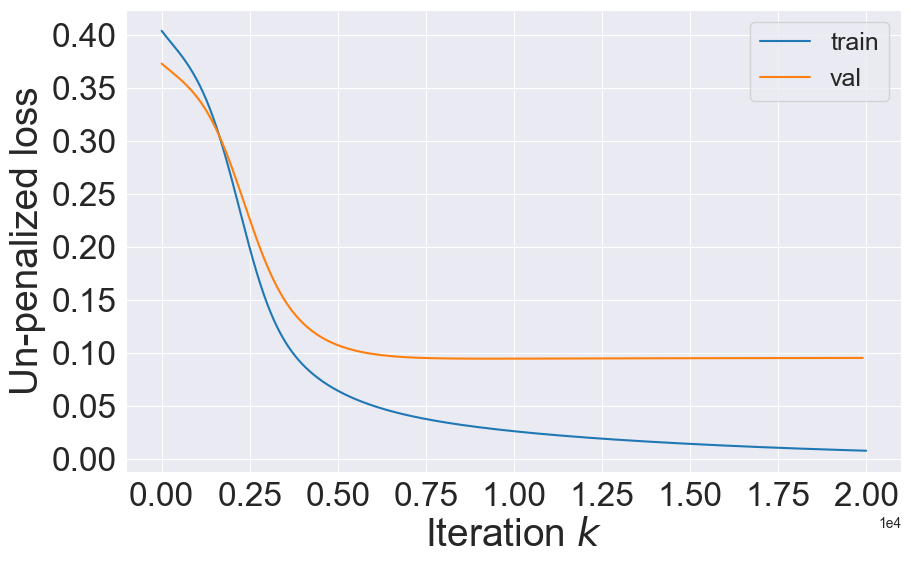

In [92]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 2. Standard conic descent: gradient descent on the empirical loss with zero init

In [24]:
n_steps = N_STEPS
m = 500
ETA = 0.001

In [25]:
def conic_particle_update(a, b, x, y):
    if a.shape[1] > 0:
        a = a - ETA * V_grad(a, b, x, y, b).reshape(1, -1)
        b = b - ETA * nabla_V_grad(a, b, x, y)
    return a, b  

In [26]:
def train(m, n_steps, x_train, y_train, x_val, y_val, do_val=True):
    a = np.zeros(shape=(1, m))
    # a = np.random.normal(size=(1, m)) / m
    b = np.random.normal(size=(m, INPUT_DIM))
    b_norms = np.linalg.norm(b, axis=1, ord=2, keepdims=True)
    b = b / b_norms
    b_0 = np.copy(b)
    
    
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []
    ms = [m]

    for k in tqdm(range(n_steps)):
        a, b = conic_particle_update(a, b, x_train, y_train)
        ms.append(a.shape[1])
        
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses) 

In [27]:
a, b, ms, train_losses, penalized_train_losses, val_losses, penalized_val_losses = \
    train(m, n_steps, x_train, y_train, x_val, y_val)

  0%|                                                        | 26/20000 [00:00<02:41, 123.58it/s]

m at step 0 : 500
Train loss at step 0 : 0.40174
Validation loss at step 0 : 0.36986


  1%|▎                                                      | 128/20000 [00:00<02:26, 136.07it/s]

m at step 100 : 500
Train loss at step 100 : 0.37896
Validation loss at step 100 : 0.34469


  1%|▌                                                      | 227/20000 [00:01<01:43, 191.03it/s]

m at step 200 : 500
Train loss at step 200 : 0.36262
Validation loss at step 200 : 0.32623


  2%|▉                                                      | 324/20000 [00:02<01:58, 165.93it/s]

m at step 300 : 500
Train loss at step 300 : 0.35085
Validation loss at step 300 : 0.31257


  2%|█▏                                                     | 424/20000 [00:02<01:47, 181.99it/s]

m at step 400 : 500
Train loss at step 400 : 0.34230
Validation loss at step 400 : 0.30239


  3%|█▍                                                     | 538/20000 [00:03<01:28, 220.94it/s]

m at step 500 : 500
Train loss at step 500 : 0.33604
Validation loss at step 500 : 0.29473


  3%|█▋                                                     | 624/20000 [00:03<01:54, 168.76it/s]

m at step 600 : 500
Train loss at step 600 : 0.33142
Validation loss at step 600 : 0.28891


  4%|██                                                     | 738/20000 [00:04<01:31, 210.19it/s]

m at step 700 : 500
Train loss at step 700 : 0.32797
Validation loss at step 700 : 0.28444


  4%|██▎                                                    | 837/20000 [00:04<01:21, 236.27it/s]

m at step 800 : 500
Train loss at step 800 : 0.32533
Validation loss at step 800 : 0.28097


  5%|██▌                                                    | 937/20000 [00:05<01:18, 242.97it/s]

m at step 900 : 500
Train loss at step 900 : 0.32328
Validation loss at step 900 : 0.27824


  5%|██▊                                                   | 1033/20000 [00:05<01:33, 203.34it/s]

m at step 1,000 : 500
Train loss at step 1,000 : 0.32165
Validation loss at step 1,000 : 0.27606


  6%|███                                                   | 1153/20000 [00:06<01:23, 225.93it/s]

m at step 1,100 : 500
Train loss at step 1,100 : 0.32030
Validation loss at step 1,100 : 0.27429


  6%|███▍                                                  | 1253/20000 [00:06<01:19, 236.33it/s]

m at step 1,200 : 500
Train loss at step 1,200 : 0.31916
Validation loss at step 1,200 : 0.27284


  7%|███▌                                                  | 1328/20000 [00:07<01:19, 234.14it/s]

m at step 1,300 : 500
Train loss at step 1,300 : 0.31815
Validation loss at step 1,300 : 0.27163


  7%|███▊                                                  | 1427/20000 [00:07<01:23, 221.12it/s]

m at step 1,400 : 500
Train loss at step 1,400 : 0.31723
Validation loss at step 1,400 : 0.27061


  8%|████▏                                                 | 1540/20000 [00:08<01:30, 203.26it/s]

m at step 1,500 : 500
Train loss at step 1,500 : 0.31638
Validation loss at step 1,500 : 0.26974


  8%|████▍                                                 | 1626/20000 [00:08<01:34, 193.45it/s]

m at step 1,600 : 500
Train loss at step 1,600 : 0.31556
Validation loss at step 1,600 : 0.26898


  9%|████▋                                                 | 1752/20000 [00:09<01:14, 243.51it/s]

m at step 1,700 : 500
Train loss at step 1,700 : 0.31476
Validation loss at step 1,700 : 0.26831


  9%|████▉                                                 | 1825/20000 [00:09<01:21, 221.88it/s]

m at step 1,800 : 500
Train loss at step 1,800 : 0.31398
Validation loss at step 1,800 : 0.26772


 10%|█████▏                                                | 1938/20000 [00:10<01:32, 195.33it/s]

m at step 1,900 : 500
Train loss at step 1,900 : 0.31320
Validation loss at step 1,900 : 0.26719


 10%|█████▍                                                | 2031/20000 [00:10<01:21, 220.90it/s]

m at step 2,000 : 500
Train loss at step 2,000 : 0.31243
Validation loss at step 2,000 : 0.26672


 11%|█████▊                                                | 2135/20000 [00:11<01:11, 248.32it/s]

m at step 2,100 : 500
Train loss at step 2,100 : 0.31167
Validation loss at step 2,100 : 0.26629


 11%|██████                                                | 2240/20000 [00:11<01:13, 242.83it/s]

m at step 2,200 : 500
Train loss at step 2,200 : 0.31091
Validation loss at step 2,200 : 0.26590


 12%|██████▎                                               | 2330/20000 [00:11<01:38, 178.71it/s]

m at step 2,300 : 500
Train loss at step 2,300 : 0.31016
Validation loss at step 2,300 : 0.26554


 12%|██████▌                                               | 2429/20000 [00:12<01:22, 212.80it/s]

m at step 2,400 : 500
Train loss at step 2,400 : 0.30941
Validation loss at step 2,400 : 0.26522


 13%|██████▊                                               | 2531/20000 [00:12<01:11, 243.92it/s]

m at step 2,500 : 500
Train loss at step 2,500 : 0.30867
Validation loss at step 2,500 : 0.26492


 13%|███████                                               | 2636/20000 [00:13<01:07, 256.49it/s]

m at step 2,600 : 500
Train loss at step 2,600 : 0.30793
Validation loss at step 2,600 : 0.26465


 14%|███████▍                                              | 2736/20000 [00:13<01:21, 212.84it/s]

m at step 2,700 : 500
Train loss at step 2,700 : 0.30720
Validation loss at step 2,700 : 0.26440


 14%|███████▋                                              | 2847/20000 [00:14<01:21, 211.67it/s]

m at step 2,800 : 500
Train loss at step 2,800 : 0.30648
Validation loss at step 2,800 : 0.26417


 15%|███████▉                                              | 2945/20000 [00:14<01:11, 238.28it/s]

m at step 2,900 : 500
Train loss at step 2,900 : 0.30576
Validation loss at step 2,900 : 0.26396


 15%|████████▏                                             | 3050/20000 [00:15<01:07, 252.65it/s]

m at step 3,000 : 500
Train loss at step 3,000 : 0.30504
Validation loss at step 3,000 : 0.26376


 16%|████████▍                                             | 3127/20000 [00:15<01:11, 235.54it/s]

m at step 3,100 : 500
Train loss at step 3,100 : 0.30434
Validation loss at step 3,100 : 0.26358


 16%|████████▊                                             | 3243/20000 [00:16<01:23, 200.98it/s]

m at step 3,200 : 500
Train loss at step 3,200 : 0.30365
Validation loss at step 3,200 : 0.26341


 17%|█████████                                             | 3340/20000 [00:16<01:16, 218.30it/s]

m at step 3,300 : 500
Train loss at step 3,300 : 0.30299
Validation loss at step 3,300 : 0.26327


 17%|█████████▎                                            | 3445/20000 [00:16<01:05, 251.26it/s]

m at step 3,400 : 500
Train loss at step 3,400 : 0.30234
Validation loss at step 3,400 : 0.26314


 18%|█████████▌                                            | 3553/20000 [00:17<01:03, 260.44it/s]

m at step 3,500 : 500
Train loss at step 3,500 : 0.30171
Validation loss at step 3,500 : 0.26302


 18%|█████████▊                                            | 3630/20000 [00:17<01:17, 210.16it/s]

m at step 3,600 : 500
Train loss at step 3,600 : 0.30110
Validation loss at step 3,600 : 0.26292


 19%|██████████▏                                           | 3755/20000 [00:18<01:09, 234.17it/s]

m at step 3,700 : 500
Train loss at step 3,700 : 0.30051
Validation loss at step 3,700 : 0.26284


 19%|██████████▎                                           | 3831/20000 [00:18<01:08, 235.77it/s]

m at step 3,800 : 500
Train loss at step 3,800 : 0.29994
Validation loss at step 3,800 : 0.26276


 20%|██████████▋                                           | 3936/20000 [00:19<01:03, 253.10it/s]

m at step 3,900 : 500
Train loss at step 3,900 : 0.29938
Validation loss at step 3,900 : 0.26269


 20%|██████████▉                                           | 4041/20000 [00:19<01:07, 235.43it/s]

m at step 4,000 : 500
Train loss at step 4,000 : 0.29885
Validation loss at step 4,000 : 0.26263


 21%|███████████▏                                          | 4135/20000 [00:20<01:21, 194.11it/s]

m at step 4,100 : 500
Train loss at step 4,100 : 0.29833
Validation loss at step 4,100 : 0.26258


 21%|███████████▍                                          | 4236/20000 [00:20<01:08, 228.88it/s]

m at step 4,200 : 500
Train loss at step 4,200 : 0.29784
Validation loss at step 4,200 : 0.26254


 22%|███████████▋                                          | 4342/20000 [00:20<01:03, 247.04it/s]

m at step 4,300 : 500
Train loss at step 4,300 : 0.29736
Validation loss at step 4,300 : 0.26251


 22%|███████████▉                                          | 4444/20000 [00:21<01:02, 247.88it/s]

m at step 4,400 : 500
Train loss at step 4,400 : 0.29692
Validation loss at step 4,400 : 0.26249


 23%|████████████▏                                         | 4517/20000 [00:21<01:09, 223.90it/s]

m at step 4,500 : 500
Train loss at step 4,500 : 0.29648
Validation loss at step 4,500 : 0.26248


 23%|████████████▌                                         | 4640/20000 [00:22<01:07, 226.42it/s]

m at step 4,600 : 500
Train loss at step 4,600 : 0.29607
Validation loss at step 4,600 : 0.26247


 24%|████████████▊                                         | 4741/20000 [00:22<01:03, 241.64it/s]

m at step 4,700 : 500
Train loss at step 4,700 : 0.29567
Validation loss at step 4,700 : 0.26247


 24%|█████████████                                         | 4845/20000 [00:23<01:00, 252.49it/s]

m at step 4,800 : 500
Train loss at step 4,800 : 0.29528
Validation loss at step 4,800 : 0.26247


 25%|█████████████▎                                        | 4923/20000 [00:23<01:00, 247.37it/s]

m at step 4,900 : 500
Train loss at step 4,900 : 0.29491
Validation loss at step 4,900 : 0.26249


 25%|█████████████▌                                        | 5041/20000 [00:24<01:15, 198.58it/s]

m at step 5,000 : 500
Train loss at step 5,000 : 0.29456
Validation loss at step 5,000 : 0.26250


 26%|█████████████▉                                        | 5141/20000 [00:24<01:05, 225.32it/s]

m at step 5,100 : 500
Train loss at step 5,100 : 0.29423
Validation loss at step 5,100 : 0.26253


 26%|██████████████▏                                       | 5246/20000 [00:24<00:59, 248.91it/s]

m at step 5,200 : 500
Train loss at step 5,200 : 0.29392
Validation loss at step 5,200 : 0.26256


 27%|██████████████▍                                       | 5351/20000 [00:25<00:57, 255.32it/s]

m at step 5,300 : 500
Train loss at step 5,300 : 0.29363
Validation loss at step 5,300 : 0.26260


 27%|██████████████▋                                       | 5425/20000 [00:25<01:06, 218.17it/s]

m at step 5,400 : 500
Train loss at step 5,400 : 0.29336
Validation loss at step 5,400 : 0.26264


 28%|██████████████▉                                       | 5545/20000 [00:26<01:04, 224.60it/s]

m at step 5,500 : 500
Train loss at step 5,500 : 0.29311
Validation loss at step 5,500 : 0.26269


 28%|███████████████▏                                      | 5637/20000 [00:26<01:11, 200.94it/s]

m at step 5,600 : 500
Train loss at step 5,600 : 0.29288
Validation loss at step 5,600 : 0.26274


 29%|███████████████▌                                      | 5742/20000 [00:27<00:58, 244.32it/s]

m at step 5,700 : 500
Train loss at step 5,700 : 0.29266
Validation loss at step 5,700 : 0.26280


 29%|███████████████▊                                      | 5841/20000 [00:27<01:01, 231.17it/s]

m at step 5,800 : 500
Train loss at step 5,800 : 0.29246
Validation loss at step 5,800 : 0.26287


 30%|████████████████                                      | 5936/20000 [00:28<01:07, 208.44it/s]

m at step 5,900 : 500
Train loss at step 5,900 : 0.29228
Validation loss at step 5,900 : 0.26294


 30%|████████████████▎                                     | 6033/20000 [00:28<01:03, 220.88it/s]

m at step 6,000 : 500
Train loss at step 6,000 : 0.29211
Validation loss at step 6,000 : 0.26301


 31%|████████████████▌                                     | 6136/20000 [00:28<00:56, 246.30it/s]

m at step 6,100 : 500
Train loss at step 6,100 : 0.29196
Validation loss at step 6,100 : 0.26310


 31%|████████████████▊                                     | 6241/20000 [00:29<00:55, 247.11it/s]

m at step 6,200 : 500
Train loss at step 6,200 : 0.29183
Validation loss at step 6,200 : 0.26319


 32%|█████████████████                                     | 6313/20000 [00:29<01:14, 183.04it/s]

m at step 6,300 : 500
Train loss at step 6,300 : 0.29171
Validation loss at step 6,300 : 0.26328


 32%|█████████████████▍                                    | 6437/20000 [00:30<00:58, 231.56it/s]

m at step 6,400 : 500
Train loss at step 6,400 : 0.29162
Validation loss at step 6,400 : 0.26338


 33%|█████████████████▋                                    | 6540/20000 [00:30<00:54, 246.31it/s]

m at step 6,500 : 500
Train loss at step 6,500 : 0.29153
Validation loss at step 6,500 : 0.26348


 33%|█████████████████▉                                    | 6645/20000 [00:31<00:52, 255.51it/s]

m at step 6,600 : 500
Train loss at step 6,600 : 0.29146
Validation loss at step 6,600 : 0.26359


 34%|██████████████████▏                                   | 6746/20000 [00:31<00:59, 224.61it/s]

m at step 6,700 : 500
Train loss at step 6,700 : 0.29140
Validation loss at step 6,700 : 0.26370


 34%|██████████████████▍                                   | 6842/20000 [00:32<01:01, 212.83it/s]

m at step 6,800 : 500
Train loss at step 6,800 : 0.29136
Validation loss at step 6,800 : 0.26382


 35%|██████████████████▋                                   | 6937/20000 [00:32<00:57, 227.29it/s]

m at step 6,900 : 500
Train loss at step 6,900 : 0.29134
Validation loss at step 6,900 : 0.26394


 35%|███████████████████                                   | 7042/20000 [00:33<00:51, 249.83it/s]

m at step 7,000 : 500
Train loss at step 7,000 : 0.29132
Validation loss at step 7,000 : 0.26407


 36%|███████████████████▎                                  | 7148/20000 [00:33<00:53, 242.16it/s]

m at step 7,100 : 500
Train loss at step 7,100 : 0.29133
Validation loss at step 7,100 : 0.26420


 36%|███████████████████▍                                  | 7219/20000 [00:33<01:14, 171.73it/s]

m at step 7,200 : 500
Train loss at step 7,200 : 0.29135
Validation loss at step 7,200 : 0.26435


 37%|███████████████████▊                                  | 7342/20000 [00:34<00:55, 227.99it/s]

m at step 7,300 : 500
Train loss at step 7,300 : 0.29138
Validation loss at step 7,300 : 0.26449


 37%|████████████████████                                  | 7446/20000 [00:34<00:50, 247.17it/s]

m at step 7,400 : 500
Train loss at step 7,400 : 0.29142
Validation loss at step 7,400 : 0.26465


 38%|████████████████████▍                                 | 7550/20000 [00:35<00:48, 255.46it/s]

m at step 7,500 : 500
Train loss at step 7,500 : 0.29149
Validation loss at step 7,500 : 0.26481


 38%|████████████████████▌                                 | 7627/20000 [00:35<00:52, 237.16it/s]

m at step 7,600 : 500
Train loss at step 7,600 : 0.29156
Validation loss at step 7,600 : 0.26498


 39%|████████████████████▉                                 | 7751/20000 [00:36<00:54, 224.03it/s]

m at step 7,700 : 500
Train loss at step 7,700 : 0.29164
Validation loss at step 7,700 : 0.26515


 39%|█████████████████████▏                                | 7848/20000 [00:36<00:53, 227.38it/s]

m at step 7,800 : 500
Train loss at step 7,800 : 0.29174
Validation loss at step 7,800 : 0.26533


 40%|█████████████████████▍                                | 7949/20000 [00:37<00:49, 243.49it/s]

m at step 7,900 : 500
Train loss at step 7,900 : 0.29184
Validation loss at step 7,900 : 0.26551


 40%|█████████████████████▋                                | 8025/20000 [00:37<00:50, 238.42it/s]

m at step 8,000 : 500
Train loss at step 8,000 : 0.29196
Validation loss at step 8,000 : 0.26571


 41%|█████████████████████▉                                | 8141/20000 [00:38<01:01, 191.58it/s]

m at step 8,100 : 500
Train loss at step 8,100 : 0.29209
Validation loss at step 8,100 : 0.26590


 41%|██████████████████████▎                               | 8242/20000 [00:38<00:52, 224.51it/s]

m at step 8,200 : 500
Train loss at step 8,200 : 0.29224
Validation loss at step 8,200 : 0.26611


 42%|██████████████████████▌                               | 8347/20000 [00:38<00:46, 248.99it/s]

m at step 8,300 : 500
Train loss at step 8,300 : 0.29240
Validation loss at step 8,300 : 0.26632


 42%|██████████████████████▊                               | 8449/20000 [00:39<00:46, 246.49it/s]

m at step 8,400 : 500
Train loss at step 8,400 : 0.29257
Validation loss at step 8,400 : 0.26653


 43%|███████████████████████                               | 8521/20000 [00:39<00:51, 221.50it/s]

m at step 8,500 : 500
Train loss at step 8,500 : 0.29276
Validation loss at step 8,500 : 0.26675


 43%|███████████████████████▎                              | 8636/20000 [00:40<00:52, 214.72it/s]

m at step 8,600 : 500
Train loss at step 8,600 : 0.29296
Validation loss at step 8,600 : 0.26698


 44%|███████████████████████▌                              | 8735/20000 [00:40<00:47, 237.22it/s]

m at step 8,700 : 500
Train loss at step 8,700 : 0.29317
Validation loss at step 8,700 : 0.26721


 44%|███████████████████████▊                              | 8840/20000 [00:41<00:44, 249.48it/s]

m at step 8,800 : 500
Train loss at step 8,800 : 0.29339
Validation loss at step 8,800 : 0.26746


 45%|████████████████████████▏                             | 8944/20000 [00:41<00:46, 237.14it/s]

m at step 8,900 : 500
Train loss at step 8,900 : 0.29362
Validation loss at step 8,900 : 0.26770


 45%|████████████████████████▍                             | 9036/20000 [00:42<00:54, 201.92it/s]

m at step 9,000 : 500
Train loss at step 9,000 : 0.29386
Validation loss at step 9,000 : 0.26795


 46%|████████████████████████▋                             | 9129/20000 [00:42<00:57, 190.42it/s]

m at step 9,100 : 500
Train loss at step 9,100 : 0.29412
Validation loss at step 9,100 : 0.26822


 46%|████████████████████████▉                             | 9229/20000 [00:42<00:46, 232.20it/s]

m at step 9,200 : 500
Train loss at step 9,200 : 0.29438
Validation loss at step 9,200 : 0.26849


 47%|█████████████████████████▏                            | 9331/20000 [00:43<00:43, 247.60it/s]

m at step 9,300 : 500
Train loss at step 9,300 : 0.29464
Validation loss at step 9,300 : 0.26877


 47%|█████████████████████████▍                            | 9405/20000 [00:43<00:53, 196.45it/s]

m at step 9,400 : 500
Train loss at step 9,400 : 0.29492
Validation loss at step 9,400 : 0.26905


 48%|█████████████████████████▋                            | 9533/20000 [00:44<00:54, 191.63it/s]

m at step 9,500 : 500
Train loss at step 9,500 : 0.29520
Validation loss at step 9,500 : 0.26933


 48%|██████████████████████████                            | 9633/20000 [00:44<00:44, 231.21it/s]

m at step 9,600 : 500
Train loss at step 9,600 : 0.29548
Validation loss at step 9,600 : 0.26962


 49%|██████████████████████████▎                           | 9736/20000 [00:45<00:41, 245.97it/s]

m at step 9,700 : 500
Train loss at step 9,700 : 0.29576
Validation loss at step 9,700 : 0.26991


 49%|██████████████████████████▍                           | 9809/20000 [00:45<00:53, 191.52it/s]

m at step 9,800 : 500
Train loss at step 9,800 : 0.29605
Validation loss at step 9,800 : 0.27020


 50%|██████████████████████████▊                           | 9931/20000 [00:46<00:43, 229.09it/s]

m at step 9,900 : 500
Train loss at step 9,900 : 0.29635
Validation loss at step 9,900 : 0.27049


 50%|██████████████████████████▌                          | 10034/20000 [00:46<00:40, 244.97it/s]

m at step 10,000 : 500
Train loss at step 10,000 : 0.29664
Validation loss at step 10,000 : 0.27078


 51%|██████████████████████████▊                          | 10139/20000 [00:47<00:38, 254.40it/s]

m at step 10,100 : 500
Train loss at step 10,100 : 0.29694
Validation loss at step 10,100 : 0.27107


 51%|███████████████████████████▏                         | 10237/20000 [00:47<00:43, 222.98it/s]

m at step 10,200 : 500
Train loss at step 10,200 : 0.29725
Validation loss at step 10,200 : 0.27137


 52%|███████████████████████████▍                         | 10334/20000 [00:48<00:45, 213.68it/s]

m at step 10,300 : 500
Train loss at step 10,300 : 0.29755
Validation loss at step 10,300 : 0.27167


 52%|███████████████████████████▋                         | 10430/20000 [00:48<00:42, 225.06it/s]

m at step 10,400 : 500
Train loss at step 10,400 : 0.29787
Validation loss at step 10,400 : 0.27198


 53%|███████████████████████████▉                         | 10533/20000 [00:49<00:38, 243.88it/s]

m at step 10,500 : 500
Train loss at step 10,500 : 0.29819
Validation loss at step 10,500 : 0.27229


 53%|████████████████████████████▏                        | 10635/20000 [00:49<00:38, 243.92it/s]

m at step 10,600 : 500
Train loss at step 10,600 : 0.29851
Validation loss at step 10,600 : 0.27261


 54%|████████████████████████████▍                        | 10724/20000 [00:49<00:52, 176.28it/s]

m at step 10,700 : 500
Train loss at step 10,700 : 0.29884
Validation loss at step 10,700 : 0.27292


 54%|████████████████████████████▋                        | 10827/20000 [00:50<00:39, 232.45it/s]

m at step 10,800 : 500
Train loss at step 10,800 : 0.29916
Validation loss at step 10,800 : 0.27324


 55%|████████████████████████████▉                        | 10930/20000 [00:50<00:36, 248.80it/s]

m at step 10,900 : 500
Train loss at step 10,900 : 0.29949
Validation loss at step 10,900 : 0.27356


 55%|█████████████████████████████▏                       | 11034/20000 [00:51<00:36, 249.03it/s]

m at step 11,000 : 500
Train loss at step 11,000 : 0.29982
Validation loss at step 11,000 : 0.27388


 56%|█████████████████████████████▍                       | 11132/20000 [00:51<00:40, 219.46it/s]

m at step 11,100 : 500
Train loss at step 11,100 : 0.30016
Validation loss at step 11,100 : 0.27420


 56%|█████████████████████████████▊                       | 11252/20000 [00:52<00:39, 223.92it/s]

m at step 11,200 : 500
Train loss at step 11,200 : 0.30050
Validation loss at step 11,200 : 0.27451


 57%|██████████████████████████████                       | 11352/20000 [00:52<00:36, 236.22it/s]

m at step 11,300 : 500
Train loss at step 11,300 : 0.30085
Validation loss at step 11,300 : 0.27483


 57%|██████████████████████████████▎                      | 11454/20000 [00:53<00:34, 248.03it/s]

m at step 11,400 : 500
Train loss at step 11,400 : 0.30119
Validation loss at step 11,400 : 0.27516


 58%|██████████████████████████████▌                      | 11530/20000 [00:53<00:35, 237.67it/s]

m at step 11,500 : 500
Train loss at step 11,500 : 0.30153
Validation loss at step 11,500 : 0.27548


 58%|██████████████████████████████▊                      | 11647/20000 [00:54<00:41, 202.04it/s]

m at step 11,600 : 500
Train loss at step 11,600 : 0.30188
Validation loss at step 11,600 : 0.27580


 59%|███████████████████████████████▏                     | 11746/20000 [00:54<00:36, 225.91it/s]

m at step 11,700 : 500
Train loss at step 11,700 : 0.30222
Validation loss at step 11,700 : 0.27613


 59%|███████████████████████████████▍                     | 11849/20000 [00:54<00:32, 249.11it/s]

m at step 11,800 : 500
Train loss at step 11,800 : 0.30258
Validation loss at step 11,800 : 0.27645


 60%|███████████████████████████████▌                     | 11929/20000 [00:55<00:31, 254.58it/s]

m at step 11,900 : 500
Train loss at step 11,900 : 0.30294
Validation loss at step 11,900 : 0.27678


 60%|███████████████████████████████▉                     | 12029/20000 [00:55<00:38, 207.16it/s]

m at step 12,000 : 500
Train loss at step 12,000 : 0.30330
Validation loss at step 12,000 : 0.27712


 61%|████████████████████████████████▏                    | 12152/20000 [00:56<00:34, 229.86it/s]

m at step 12,100 : 500
Train loss at step 12,100 : 0.30367
Validation loss at step 12,100 : 0.27745


 61%|████████████████████████████████▍                    | 12253/20000 [00:56<00:31, 243.91it/s]

m at step 12,200 : 500
Train loss at step 12,200 : 0.30404
Validation loss at step 12,200 : 0.27778


 62%|████████████████████████████████▋                    | 12329/20000 [00:57<00:31, 240.94it/s]

m at step 12,300 : 500
Train loss at step 12,300 : 0.30440
Validation loss at step 12,300 : 0.27812


 62%|████████████████████████████████▉                    | 12431/20000 [00:57<00:32, 231.92it/s]

m at step 12,400 : 500
Train loss at step 12,400 : 0.30476
Validation loss at step 12,400 : 0.27846


 63%|█████████████████████████████████▎                   | 12549/20000 [00:58<00:36, 204.61it/s]

m at step 12,500 : 500
Train loss at step 12,500 : 0.30513
Validation loss at step 12,500 : 0.27879


 63%|█████████████████████████████████▌                   | 12642/20000 [00:58<00:34, 211.81it/s]

m at step 12,600 : 500
Train loss at step 12,600 : 0.30550
Validation loss at step 12,600 : 0.27913


 64%|█████████████████████████████████▊                   | 12744/20000 [00:58<00:29, 244.03it/s]

m at step 12,700 : 500
Train loss at step 12,700 : 0.30586
Validation loss at step 12,700 : 0.27947


 64%|██████████████████████████████████                   | 12848/20000 [00:59<00:29, 244.31it/s]

m at step 12,800 : 500
Train loss at step 12,800 : 0.30622
Validation loss at step 12,800 : 0.27981


 65%|██████████████████████████████████▏                  | 12920/20000 [00:59<00:37, 186.85it/s]

m at step 12,900 : 500
Train loss at step 12,900 : 0.30658
Validation loss at step 12,900 : 0.28016


 65%|██████████████████████████████████▌                  | 13044/20000 [01:00<00:30, 230.11it/s]

m at step 13,000 : 500
Train loss at step 13,000 : 0.30694
Validation loss at step 13,000 : 0.28051


 66%|██████████████████████████████████▊                  | 13147/20000 [01:00<00:28, 243.98it/s]

m at step 13,100 : 500
Train loss at step 13,100 : 0.30730
Validation loss at step 13,100 : 0.28087


 66%|███████████████████████████████████                  | 13250/20000 [01:01<00:27, 248.85it/s]

m at step 13,200 : 500
Train loss at step 13,200 : 0.30767
Validation loss at step 13,200 : 0.28122


 67%|███████████████████████████████████▎                 | 13325/20000 [01:01<00:28, 230.54it/s]

m at step 13,300 : 500
Train loss at step 13,300 : 0.30803
Validation loss at step 13,300 : 0.28158


 67%|███████████████████████████████████▋                 | 13444/20000 [01:02<00:30, 217.49it/s]

m at step 13,400 : 500
Train loss at step 13,400 : 0.30839
Validation loss at step 13,400 : 0.28193


 68%|███████████████████████████████████▉                 | 13539/20000 [01:02<00:28, 228.41it/s]

m at step 13,500 : 500
Train loss at step 13,500 : 0.30875
Validation loss at step 13,500 : 0.28229


 68%|████████████████████████████████████▏                | 13644/20000 [01:03<00:25, 252.54it/s]

m at step 13,600 : 500
Train loss at step 13,600 : 0.30911
Validation loss at step 13,600 : 0.28264


 69%|████████████████████████████████████▎                | 13722/20000 [01:03<00:24, 251.64it/s]

m at step 13,700 : 500
Train loss at step 13,700 : 0.30946
Validation loss at step 13,700 : 0.28299


 69%|████████████████████████████████████▋                | 13835/20000 [01:03<00:34, 177.84it/s]

m at step 13,800 : 500
Train loss at step 13,800 : 0.30981
Validation loss at step 13,800 : 0.28334


 70%|████████████████████████████████████▉                | 13933/20000 [01:04<00:27, 221.96it/s]

m at step 13,900 : 500
Train loss at step 13,900 : 0.31016
Validation loss at step 13,900 : 0.28369


 70%|█████████████████████████████████████▏               | 14034/20000 [01:04<00:24, 244.24it/s]

m at step 14,000 : 500
Train loss at step 14,000 : 0.31051
Validation loss at step 14,000 : 0.28405


 71%|█████████████████████████████████████▍               | 14137/20000 [01:05<00:23, 249.32it/s]

m at step 14,100 : 500
Train loss at step 14,100 : 0.31086
Validation loss at step 14,100 : 0.28441


 71%|█████████████████████████████████████▋               | 14236/20000 [01:05<00:27, 208.92it/s]

m at step 14,200 : 500
Train loss at step 14,200 : 0.31120
Validation loss at step 14,200 : 0.28477


 72%|█████████████████████████████████████▉               | 14330/20000 [01:06<00:26, 216.93it/s]

m at step 14,300 : 500
Train loss at step 14,300 : 0.31155
Validation loss at step 14,300 : 0.28514


 72%|██████████████████████████████████████▏              | 14428/20000 [01:06<00:24, 229.41it/s]

m at step 14,400 : 500
Train loss at step 14,400 : 0.31190
Validation loss at step 14,400 : 0.28551


 73%|██████████████████████████████████████▌              | 14531/20000 [01:07<00:22, 245.21it/s]

m at step 14,500 : 500
Train loss at step 14,500 : 0.31225
Validation loss at step 14,500 : 0.28587


 73%|██████████████████████████████████████▊              | 14634/20000 [01:07<00:22, 240.19it/s]

m at step 14,600 : 500
Train loss at step 14,600 : 0.31260
Validation loss at step 14,600 : 0.28624


 74%|███████████████████████████████████████              | 14723/20000 [01:07<00:29, 179.71it/s]

m at step 14,700 : 500
Train loss at step 14,700 : 0.31295
Validation loss at step 14,700 : 0.28661


 74%|███████████████████████████████████████▎             | 14846/20000 [01:08<00:23, 222.09it/s]

m at step 14,800 : 500
Train loss at step 14,800 : 0.31329
Validation loss at step 14,800 : 0.28697


 75%|███████████████████████████████████████▌             | 14949/20000 [01:08<00:20, 249.30it/s]

m at step 14,900 : 500
Train loss at step 14,900 : 0.31363
Validation loss at step 14,900 : 0.28734


 75%|███████████████████████████████████████▊             | 15026/20000 [01:09<00:20, 242.42it/s]

m at step 15,000 : 500
Train loss at step 15,000 : 0.31397
Validation loss at step 15,000 : 0.28770


 76%|████████████████████████████████████████             | 15121/20000 [01:09<00:25, 194.97it/s]

m at step 15,100 : 500
Train loss at step 15,100 : 0.31430
Validation loss at step 15,100 : 0.28806


 76%|████████████████████████████████████████▍            | 15238/20000 [01:10<00:22, 210.87it/s]

m at step 15,200 : 500
Train loss at step 15,200 : 0.31464
Validation loss at step 15,200 : 0.28843


 77%|████████████████████████████████████████▋            | 15339/20000 [01:10<00:19, 238.20it/s]

m at step 15,300 : 500
Train loss at step 15,300 : 0.31497
Validation loss at step 15,300 : 0.28880


 77%|████████████████████████████████████████▉            | 15444/20000 [01:11<00:18, 251.89it/s]

m at step 15,400 : 500
Train loss at step 15,400 : 0.31530
Validation loss at step 15,400 : 0.28917


 78%|█████████████████████████████████████████▏           | 15544/20000 [01:11<00:19, 224.74it/s]

m at step 15,500 : 500
Train loss at step 15,500 : 0.31563
Validation loss at step 15,500 : 0.28953


 78%|█████████████████████████████████████████▍           | 15639/20000 [01:12<00:20, 210.67it/s]

m at step 15,600 : 500
Train loss at step 15,600 : 0.31595
Validation loss at step 15,600 : 0.28989


 79%|█████████████████████████████████████████▋           | 15734/20000 [01:12<00:19, 223.74it/s]

m at step 15,700 : 500
Train loss at step 15,700 : 0.31627
Validation loss at step 15,700 : 0.29025


 79%|█████████████████████████████████████████▉           | 15837/20000 [01:13<00:16, 248.76it/s]

m at step 15,800 : 500
Train loss at step 15,800 : 0.31658
Validation loss at step 15,800 : 0.29061


 80%|██████████████████████████████████████████▏          | 15939/20000 [01:13<00:17, 237.57it/s]

m at step 15,900 : 500
Train loss at step 15,900 : 0.31689
Validation loss at step 15,900 : 0.29097


 80%|██████████████████████████████████████████▍          | 16027/20000 [01:13<00:23, 171.47it/s]

m at step 16,000 : 500
Train loss at step 16,000 : 0.31720
Validation loss at step 16,000 : 0.29133


 81%|██████████████████████████████████████████▊          | 16136/20000 [01:14<00:18, 206.59it/s]

m at step 16,100 : 500
Train loss at step 16,100 : 0.31751
Validation loss at step 16,100 : 0.29170


 81%|███████████████████████████████████████████          | 16238/20000 [01:14<00:15, 244.50it/s]

m at step 16,200 : 500
Train loss at step 16,200 : 0.31782
Validation loss at step 16,200 : 0.29206


 82%|███████████████████████████████████████████▎         | 16342/20000 [01:15<00:14, 253.03it/s]

m at step 16,300 : 500
Train loss at step 16,300 : 0.31813
Validation loss at step 16,300 : 0.29243


 82%|███████████████████████████████████████████▌         | 16416/20000 [01:15<00:16, 213.42it/s]

m at step 16,400 : 500
Train loss at step 16,400 : 0.31844
Validation loss at step 16,400 : 0.29280


 83%|███████████████████████████████████████████▊         | 16536/20000 [01:16<00:15, 224.79it/s]

m at step 16,500 : 500
Train loss at step 16,500 : 0.31875
Validation loss at step 16,500 : 0.29317


 83%|████████████████████████████████████████████         | 16636/20000 [01:16<00:14, 240.08it/s]

m at step 16,600 : 500
Train loss at step 16,600 : 0.31906
Validation loss at step 16,600 : 0.29354


 84%|████████████████████████████████████████████▎        | 16740/20000 [01:17<00:13, 250.19it/s]

m at step 16,700 : 500
Train loss at step 16,700 : 0.31936
Validation loss at step 16,700 : 0.29391


 84%|████████████████████████████████████████████▌        | 16839/20000 [01:17<00:13, 231.16it/s]

m at step 16,800 : 500
Train loss at step 16,800 : 0.31966
Validation loss at step 16,800 : 0.29427


 85%|████████████████████████████████████████████▊        | 16932/20000 [01:18<00:15, 202.16it/s]

m at step 16,900 : 500
Train loss at step 16,900 : 0.31996
Validation loss at step 16,900 : 0.29463


 85%|█████████████████████████████████████████████        | 17028/20000 [01:18<00:13, 221.56it/s]

m at step 17,000 : 500
Train loss at step 17,000 : 0.32026
Validation loss at step 17,000 : 0.29499


 86%|█████████████████████████████████████████████▍       | 17132/20000 [01:18<00:11, 246.70it/s]

m at step 17,100 : 500
Train loss at step 17,100 : 0.32056
Validation loss at step 17,100 : 0.29535


 86%|█████████████████████████████████████████████▋       | 17236/20000 [01:19<00:10, 253.40it/s]

m at step 17,200 : 500
Train loss at step 17,200 : 0.32085
Validation loss at step 17,200 : 0.29571


 87%|█████████████████████████████████████████████▊       | 17310/20000 [01:19<00:13, 202.03it/s]

m at step 17,300 : 500
Train loss at step 17,300 : 0.32114
Validation loss at step 17,300 : 0.29606


 87%|██████████████████████████████████████████████▏      | 17430/20000 [01:20<00:11, 227.22it/s]

m at step 17,400 : 500
Train loss at step 17,400 : 0.32144
Validation loss at step 17,400 : 0.29641


 88%|██████████████████████████████████████████████▍      | 17532/20000 [01:20<00:10, 242.89it/s]

m at step 17,500 : 500
Train loss at step 17,500 : 0.32173
Validation loss at step 17,500 : 0.29677


 88%|██████████████████████████████████████████████▋      | 17636/20000 [01:21<00:09, 252.98it/s]

m at step 17,600 : 500
Train loss at step 17,600 : 0.32202
Validation loss at step 17,600 : 0.29712


 89%|██████████████████████████████████████████████▉      | 17735/20000 [01:21<00:09, 230.41it/s]

m at step 17,700 : 500
Train loss at step 17,700 : 0.32231
Validation loss at step 17,700 : 0.29748


 89%|███████████████████████████████████████████████▎     | 17831/20000 [01:22<00:10, 207.65it/s]

m at step 17,800 : 500
Train loss at step 17,800 : 0.32260
Validation loss at step 17,800 : 0.29783


 90%|███████████████████████████████████████████████▌     | 17929/20000 [01:22<00:09, 223.86it/s]

m at step 17,900 : 500
Train loss at step 17,900 : 0.32290
Validation loss at step 17,900 : 0.29819


 90%|███████████████████████████████████████████████▊     | 18031/20000 [01:22<00:07, 247.92it/s]

m at step 18,000 : 500
Train loss at step 18,000 : 0.32319
Validation loss at step 18,000 : 0.29855


 91%|████████████████████████████████████████████████     | 18134/20000 [01:23<00:07, 246.78it/s]

m at step 18,100 : 500
Train loss at step 18,100 : 0.32348
Validation loss at step 18,100 : 0.29890


 91%|████████████████████████████████████████████████▎    | 18226/20000 [01:23<00:10, 176.91it/s]

m at step 18,200 : 500
Train loss at step 18,200 : 0.32377
Validation loss at step 18,200 : 0.29926


 92%|████████████████████████████████████████████████▌    | 18348/20000 [01:24<00:07, 220.54it/s]

m at step 18,300 : 500
Train loss at step 18,300 : 0.32406
Validation loss at step 18,300 : 0.29962


 92%|████████████████████████████████████████████████▉    | 18451/20000 [01:24<00:06, 247.86it/s]

m at step 18,400 : 500
Train loss at step 18,400 : 0.32435
Validation loss at step 18,400 : 0.29997


 93%|█████████████████████████████████████████████████    | 18530/20000 [01:25<00:05, 253.58it/s]

m at step 18,500 : 500
Train loss at step 18,500 : 0.32464
Validation loss at step 18,500 : 0.30033


 93%|█████████████████████████████████████████████████▎   | 18629/20000 [01:25<00:06, 224.62it/s]

m at step 18,600 : 500
Train loss at step 18,600 : 0.32492
Validation loss at step 18,600 : 0.30069


 94%|█████████████████████████████████████████████████▋   | 18752/20000 [01:26<00:05, 224.62it/s]

m at step 18,700 : 500
Train loss at step 18,700 : 0.32520
Validation loss at step 18,700 : 0.30104


 94%|█████████████████████████████████████████████████▉   | 18853/20000 [01:26<00:04, 239.19it/s]

m at step 18,800 : 500
Train loss at step 18,800 : 0.32548
Validation loss at step 18,800 : 0.30139


 95%|██████████████████████████████████████████████████▏  | 18931/20000 [01:27<00:04, 248.41it/s]

m at step 18,900 : 500
Train loss at step 18,900 : 0.32576
Validation loss at step 18,900 : 0.30173


 95%|██████████████████████████████████████████████████▍  | 19034/20000 [01:27<00:03, 245.00it/s]

m at step 19,000 : 500
Train loss at step 19,000 : 0.32603
Validation loss at step 19,000 : 0.30207


 96%|██████████████████████████████████████████████████▋  | 19124/20000 [01:27<00:04, 176.88it/s]

m at step 19,100 : 500
Train loss at step 19,100 : 0.32630
Validation loss at step 19,100 : 0.30240


 96%|██████████████████████████████████████████████████▉  | 19224/20000 [01:28<00:03, 226.30it/s]

m at step 19,200 : 500
Train loss at step 19,200 : 0.32657
Validation loss at step 19,200 : 0.30274


 97%|███████████████████████████████████████████████████▎ | 19352/20000 [01:28<00:02, 246.95it/s]

m at step 19,300 : 500
Train loss at step 19,300 : 0.32684
Validation loss at step 19,300 : 0.30307


 97%|███████████████████████████████████████████████████▍ | 19430/20000 [01:29<00:02, 252.45it/s]

m at step 19,400 : 500
Train loss at step 19,400 : 0.32711
Validation loss at step 19,400 : 0.30341


 98%|███████████████████████████████████████████████████▋ | 19527/20000 [01:29<00:02, 203.55it/s]

m at step 19,500 : 500
Train loss at step 19,500 : 0.32738
Validation loss at step 19,500 : 0.30374


 98%|████████████████████████████████████████████████████ | 19646/20000 [01:30<00:01, 227.15it/s]

m at step 19,600 : 500
Train loss at step 19,600 : 0.32765
Validation loss at step 19,600 : 0.30408


 99%|████████████████████████████████████████████████████▎| 19747/20000 [01:30<00:01, 240.18it/s]

m at step 19,700 : 500
Train loss at step 19,700 : 0.32792
Validation loss at step 19,700 : 0.30442


 99%|████████████████████████████████████████████████████▌| 19852/20000 [01:31<00:00, 252.05it/s]

m at step 19,800 : 500
Train loss at step 19,800 : 0.32819
Validation loss at step 19,800 : 0.30476


100%|████████████████████████████████████████████████████▊| 19928/20000 [01:31<00:00, 234.62it/s]

m at step 19,900 : 500
Train loss at step 19,900 : 0.32846
Validation loss at step 19,900 : 0.30509


100%|█████████████████████████████████████████████████████| 20000/20000 [01:31<00:00, 217.54it/s]


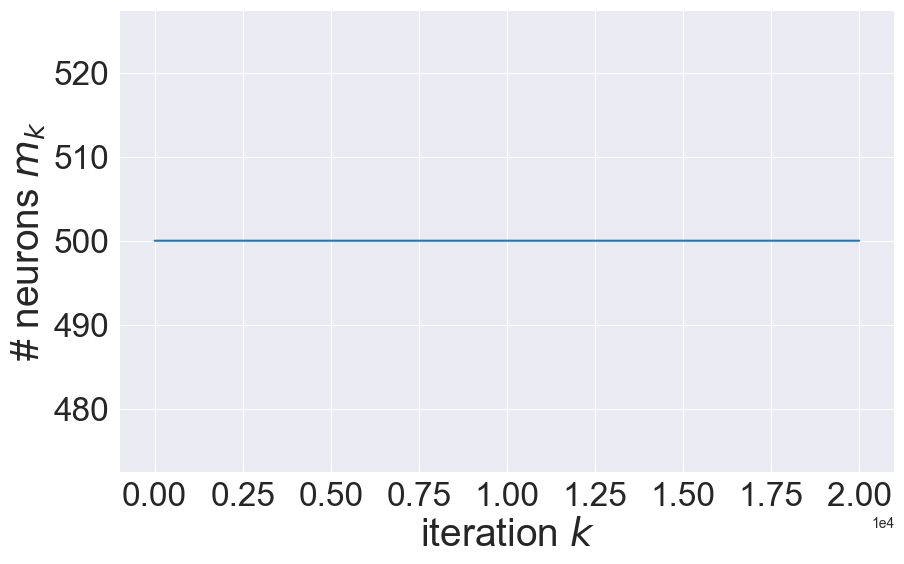

In [28]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms)), ms, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

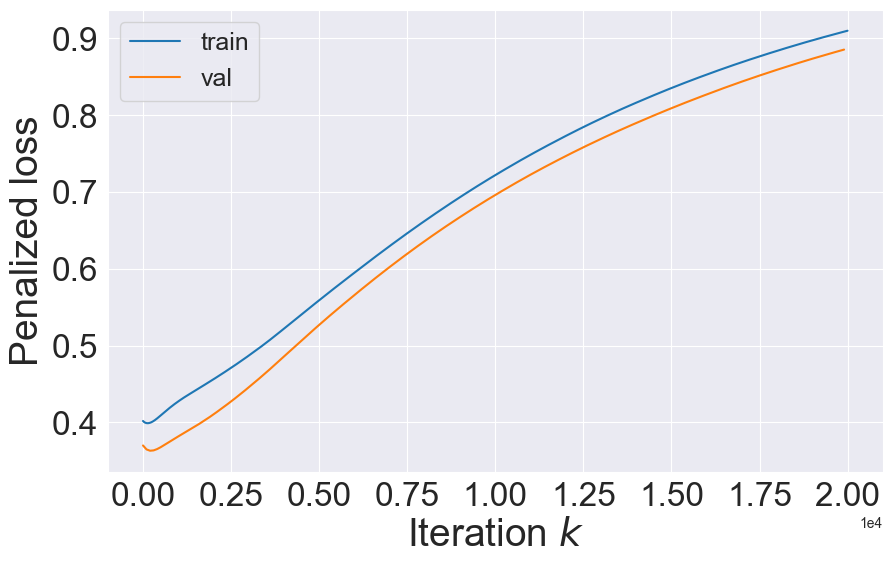

In [29]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses)), penalized_train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

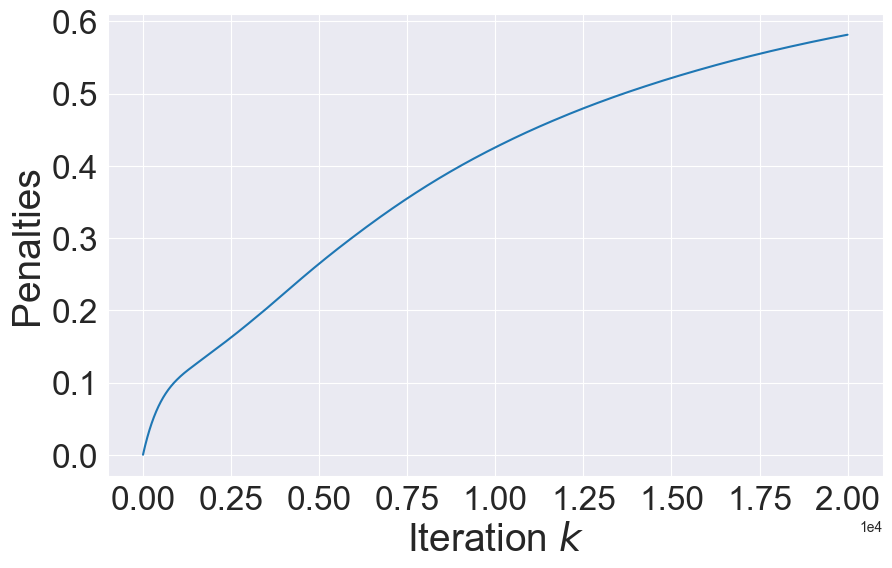

In [30]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses - train_losses

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

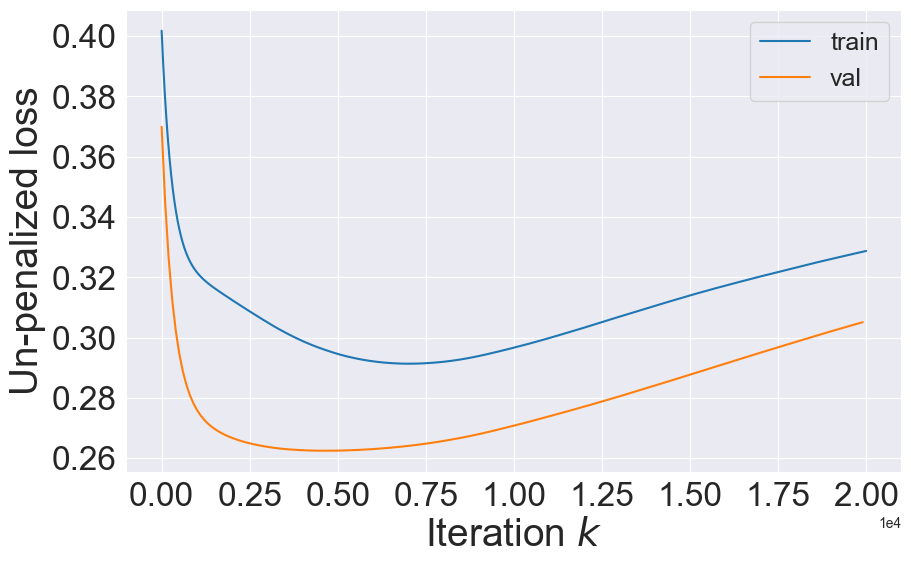

In [31]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()